# A/B Testing - Bayesian Estimation

Large parts of __frequentist hypothesis testing__ are typically __centered around two concepts: $p$-values and confidence intervals__. While the former is being used to decide wether a null hypothesis is rejected or not, the latter helps to express the uncertainty about estimated parameters (e.g. difference in means between two groups). Despite serving as tools for decision making both $p$-values and confidence intervals do not only provide limited information, but are often difficult to explain to stakeholders such as marketing and product/business managers.

While stakeholders often rather want to know '_... the probability that my alternative is better than the the null_', the $p$-value informs us about the probability of observing a value of some test statistic (e.g. $t$ statistic when doing $t$-tests) at least as extreme given the null hypothesis is true. Or in other words, it's the probability of committing a type I error (false-positive) and only if this probability is small enough, usually $p$ < .05, we reject $H0$. Another confusion often occurs around confidence intervals. A confidence interval doesn't carry any distributional information thus an estimated parameter of interest is not more likely than any value within that interval's range. And because they are strictly tied to $p$-values, the only thing we can say is that a confidence interval covers all possible parameter values that would not be rejected by $p$ < .05.

In this notebook we try to explore how Bayesian inference differs from frequentist approaches and how robust Bayesian estimation can help to overcome known issues related to classical hypothesis testing.

## Bayesian Inference
By using sample data both frequentist and Bayesian inference allow us to derive the (often unknown) properties of a larger population (e.g. center and spread i.e. mean and standard deviation). While frequentists treat unknown parameters like the mean as constant and fixed and base any probabilistic statement on long-term frequencies only, Bayesians consider them to be random variables, each with their own probability distribution. An important distinction is that in Bayesian data analysis __probability is not only defined by past observations, but also by prior beliefs__. New observations are used to update such beliefs. And in fact, this way of thinking about probabilities is exactly what you apply in your day to day life.

In Bayesian inference we always start with prior assumptions regarding the probability of parameters measured in an A/B test. Such assumptions are typically expressed as probability distributions and are based on comparable experiments and past oberservations. Both prior assumptions and collected data during the runtime of a test are then used to form what we call the __posterior__. Finally, we use the posterior (short for posterior probability) distributions of our test and control groups to compare parameter values and make inference. More formally, estimating the posterior probability based on prior and likelihood happens by applying __Baye's rule__: 

\begin{equation*}
P(\theta|D) = \frac{P(D|\theta) * P(\theta)}{P(D)}
\end{equation*}

where
- $\theta$ is the parameter of interest
- $D$ is the evidence and corresponds to newly collected data 
- $P(\theta|D)$ is the _posterior probability_
- $P(\theta)$ is the _prior probability_ 
- $P(D|\theta)$ is the _likelihood_
- $P(D)$ is the _marginal likelihood_

Again, what's great about Bayesian inference is that we can explicitely incorporate prior information (which is also often available) into an analysis. However, situations may exist in which it's difficult to decide on prior probability distributions as well as their corresponding parameters. In general, prior distributions can be put into three categories:
- __Informative prior__:
    - Whenever we have prior knowledge about the parameters of interest, e.g. conversion rates from an earlier A/B test or the average number of any event over the course of a month, we speak of an informative, sometimes called subjective prior. As an example, conversion rates may be expressed as Binomial distributions.
- __Weakly informative prior__:
    - Even when the information at hand is very vague we can still make sure to rule out unreasonable estimates by specifying a weakly informative prior. For example, if the number of activities of a user can not be negative we might want to limit a corresponding prior to an appropriate range.
- __Non-informative prior__:
    - If there is no prior information available at all (which is rarely the case in an online environment) we speak of non-informative, sometimes called objective priors. In these cases prior distributions can be expressed as distributions which don't favor any value over another. Examples are Uniform distributions or Normal distributions with very large variance. When choosing non-informative priors (almost) all inference made on the posterior results from the likelihood.

### Conjugate Priors
In real life situations estimating the posterior often means computing a difficult integral. A convenient way around this is to use prior distributions for the likelihood which are _conjugate_. Distributions are _conjuagte_ to the likelihood when prior and posterior are from the same parametric family and when prior and posterior share the same functional form. Instead of numerical integration conjugate priors allow us to estimate the posterior in closed-form (which is easy to calculate).

Some of the most prominent examples are:
- __Beta__ distribution as conjugate prior for a __Binomial__ likelihood (e.g. conversion rates) to obtain a posterior which follows a Beta distribution as well
- __Normal__ distribution as conjugate prior for __Normal__ likelihood to obtain a posterior which follows a Normal distribution as well (_self-conjugate_)
- __Normal-Gamma__ ...

In the following we look at a simple example on how both prior and likelihood inform the posterior distribution in Bayesian inference and how conjugate priors - if available - can help achieving an analytical solution without the need to solve a complex integral.

#### Example: Beta Prior
One of the common metrics used for the comparison of groups in an A/B test is the conversion rate. Conversion events can in fact be describes as a sequence of 0s and 1s and can therefore be modeled and understood as Binomial distribution. Now, the concept of _conjugacy_ tells us that if the likelihood follows a Binomial distribution we're able to express prior beliefs as Beta distributions. And by _updating_ the parameters of the prior we obtain a posterior following a Beta distribution as well. The huge benefit of using the __Beta distribution__ is that there is an exact solution which we can __solve analytically__ in ```R```.

Let's import all the libraries required for the rest of this notebook before seeing this in action below.

In [5]:
# Load libraries
require('HDInterval') # devtools::install_github("mikemeredith/HDInterval")
require('MASS')
require('reshape')
require('repr')
require('ggplot2')
require('grid')
require('gridExtra')

Next, we create some __toy data__:
- Vector with conversion events which we want to use to express our prior beliefs regarding the true conversion rate
- Vector with conversion events which we observe during an A/B test

In [6]:
# Create some toy data
y_prior <- c(replicate(2231, 1), replicate(35326-2231, 0)) # used for prior of control
y_control <- c(replicate(6898, 1), replicate(98215-6898, 0)) # used for observations of control

print(paste0("Sample mean of oberservations used for prior: ",round(mean(y_prior), 5)))
print(paste0("Sample mean of oberservations used for likelihood of control: ",round(mean(y_control), 5)))

[1] "Sample mean of oberservations used for prior: 0.06315"
[1] "Sample mean of oberservations used for likelihood of control: 0.07023"


So, how exactly do we __specify a Beta prior__? The Beta distribution requires two parameters: $a$ and $\beta$. We can calculate these parameters from the sequence of conversion events created above:
- $a$ is the number of successful conversions
- $\beta$ is the number of unsuccessful conversions

It's important to note that the more observations we seek to incorporate into a prior (greater $a$ and $\beta$ i.e. greater amount of certainty) the more influence it'll have on the posterior distribution. Especially in situations where the influence of significant changes is evaluated in an A/B test it can be useful to introduce an additional scaling parameter which allows to express uncertainty regarding previously seen results.

In [7]:
# Get alpha and beta parameters for prior
# (scale alpha and beta if you want)
mu <- mean(y_prior)
n <- length(y_prior)
scale <- 0.99
alpha <- mu*n * scale
beta <- (1-mu) * n * scale

Recall: If the prior follows a Beta distribution than the posterior follows Beta distribution as well. And - as follows - we get its parameters by _updating_ both our prior $a$ and $\beta$ with __observations from the likelihood__.

In [8]:
# Get parameters for posterior
z <- sum(y_control)
N <- length(y_control)
alpha_post = alpha + z
beta_post <- beta + N-z

With $a$ and $\beta$ parameters in place for both prior and posterior, we take a closer look at the __probability densities of all three distributions__. Plotting each of them on the same interval between zero and one will help us to improve the understanding about the influence of prior and likelihood on the posterior.

In [9]:
# Construct grid of theta values, used for graphing
# (arbitrary small value for theta)
binwidth = 0.001 
thetas <- seq(from = 0.055, to = 0.075, by = binwidth/100)

# P(theta) at each value of theta
prior <- dbeta(thetas, alpha, beta)

# P(data|theta) at each value of theta
likelihood <- dbinom(x = z, size = N, prob = thetas)

# P(theta|data) at each value of theta
posterior <- dbeta(thetas, alpha_post, beta_post)

Short __summary__ of posterior ...

In [10]:
# Params of posterior
post_mean <- alpha_post / (alpha_post+beta_post)
post_mode <- (alpha_post-1) / (alpha_post+beta_post-2)
post_sd <- sqrt(alpha_post*beta_post / ((alpha_post+beta_post)^2 * (alpha_post+beta_post+1)))

# Summary
print(paste0("Summary of posterior:"))
print(paste0("Mean: ", round(mean(post_mean), 5)))
print(paste0("Mode: ", round(mean(post_mode), 5)))

[1] "Summary of posterior:"
[1] "Mean: 0.06837"
[1] "Mode: 0.06837"


... before creating the __plots__.

In [11]:
# Combine distributions and prepare before plotting
dists <- data.frame(cbind(thetas, prior, likelihood, posterior))
dists <- melt(dists, id.vars = "thetas")

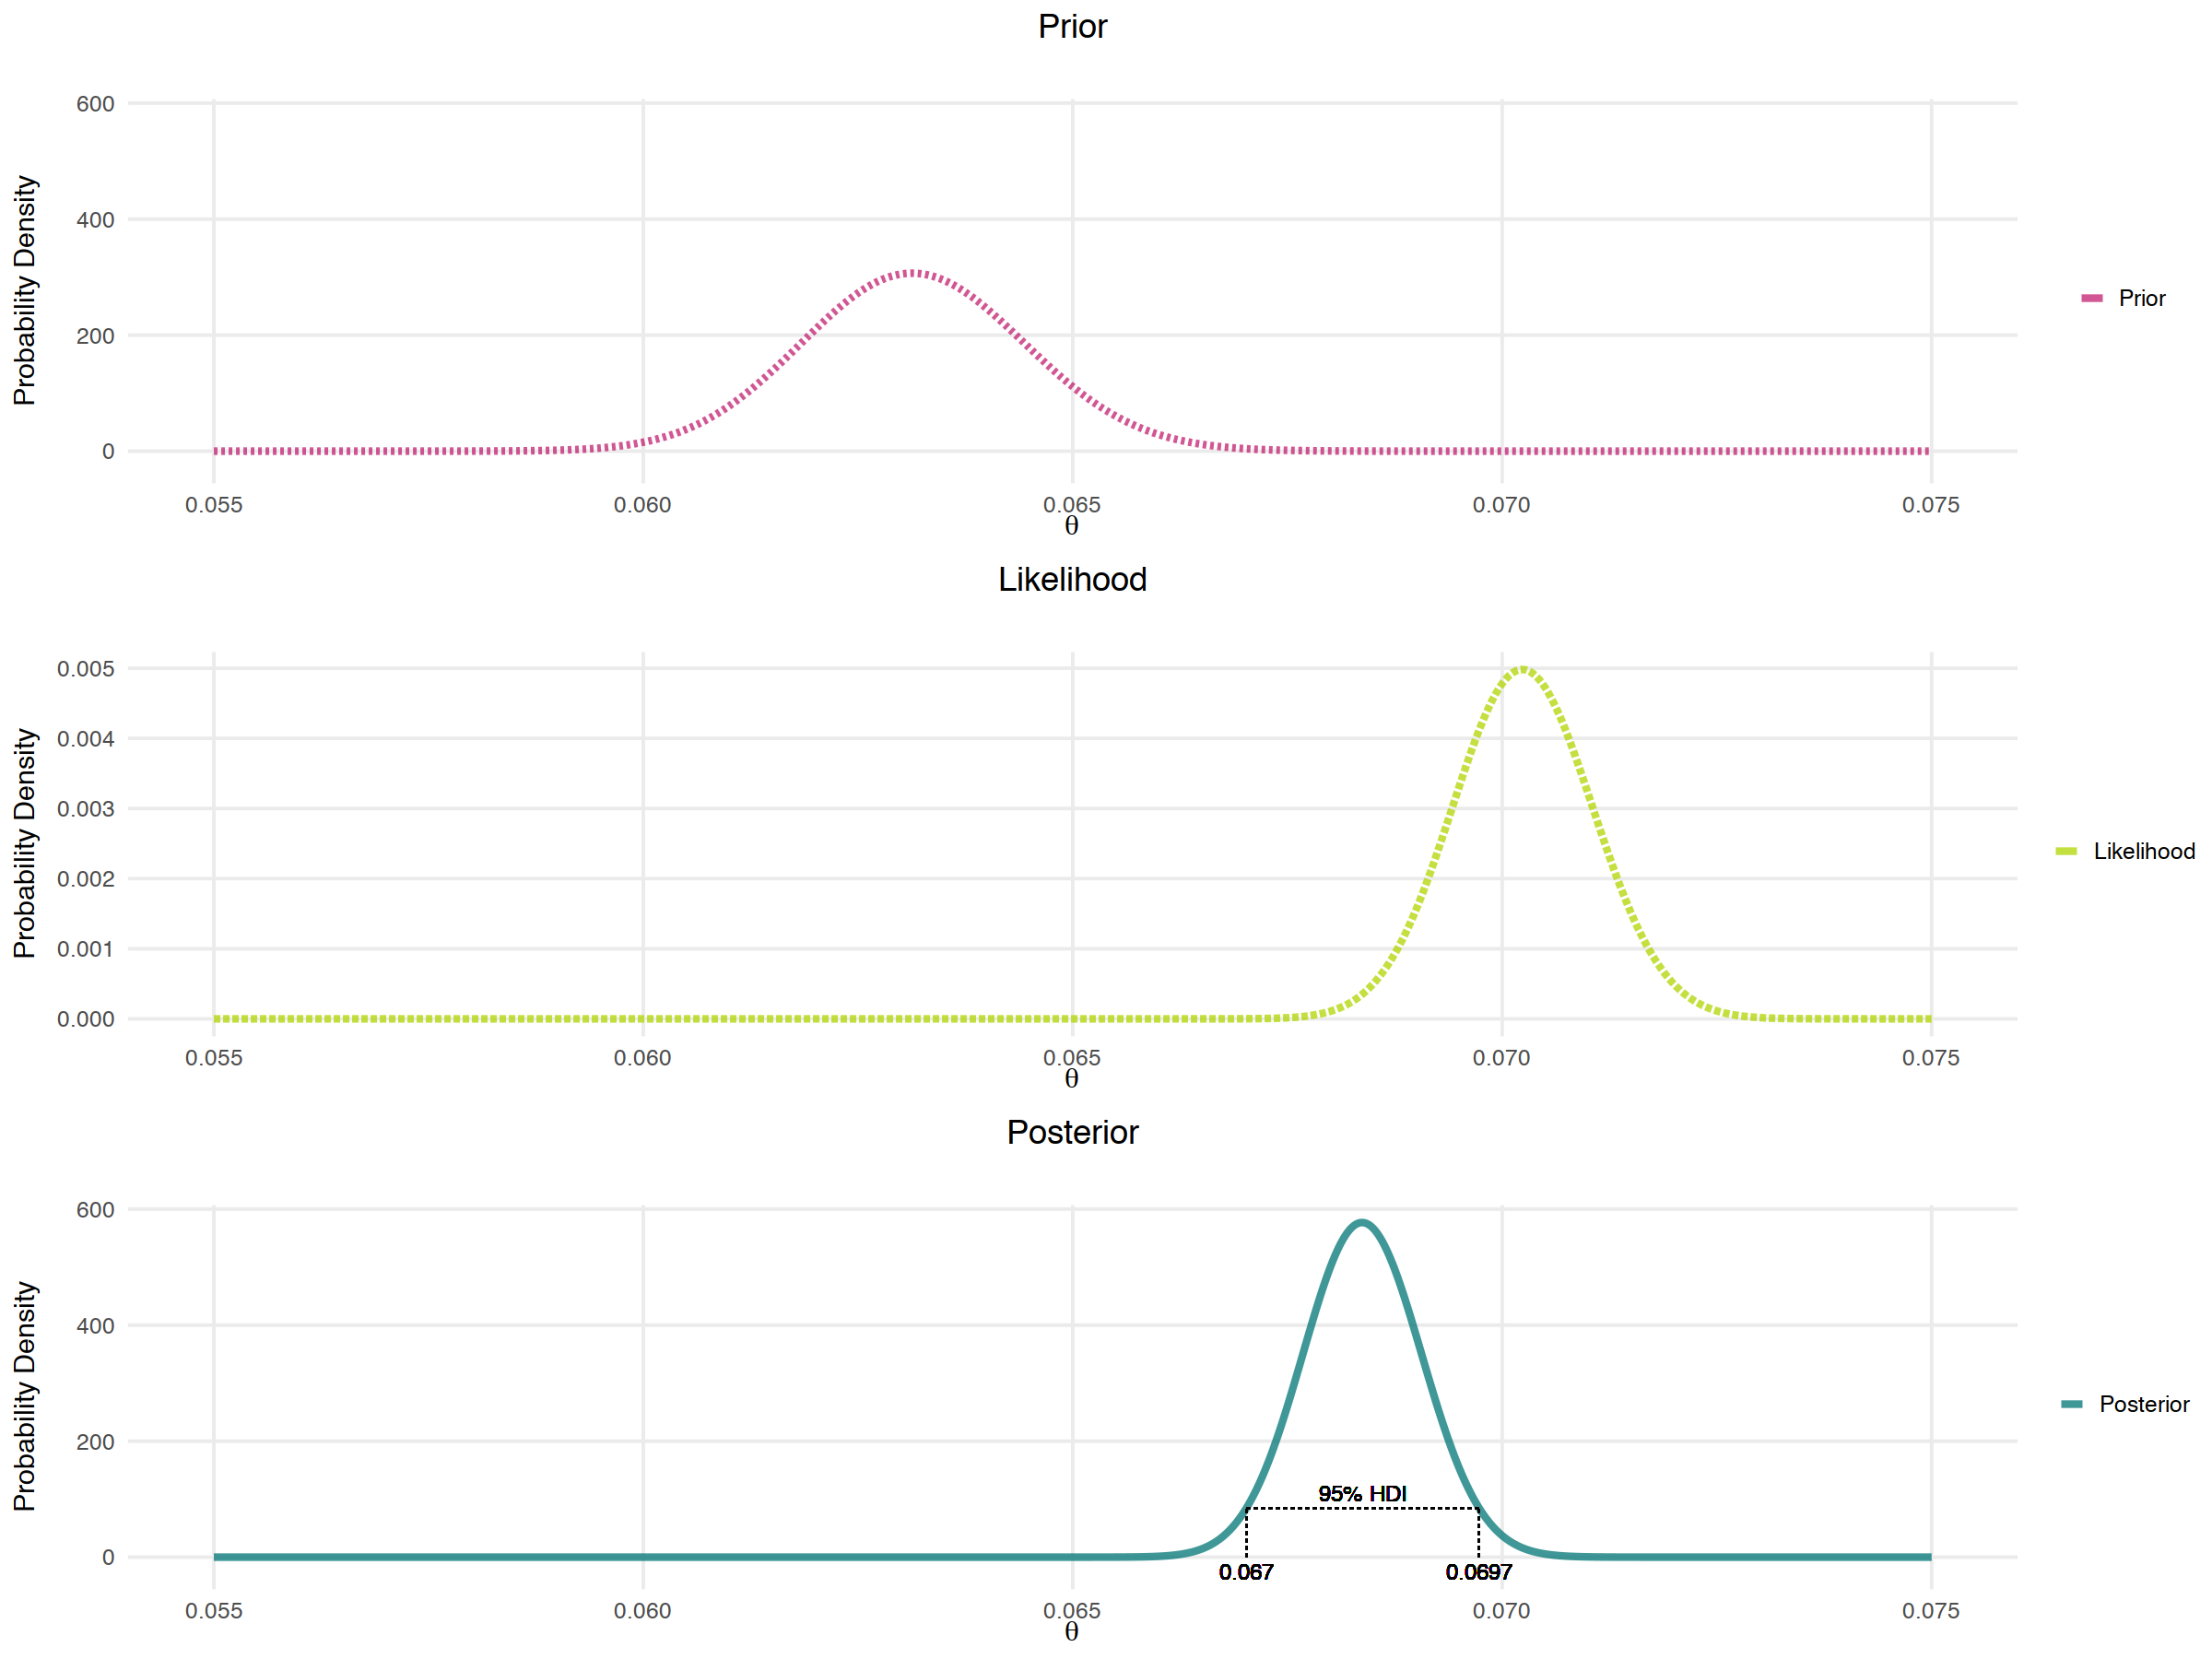

In [12]:
# Initialize helper objects
plots <- list()
labels <- c("Prior", "Likelihood", "Posterior")
linetypes <- c("dashed","longdash","solid")
colors <- c("#C21F70","#B0D400","#007575")

# Create plot objects
for (i in 1:length(labels)){
    plots[[i]] <- ggplot(dists[dists$variable == tolower(labels[i]),], aes(x = thetas, y = value, group = variable, colour = variable, linetype = variable)) + 
        geom_line(size = 1.75, alpha = 0.75) +
        xlim(0.055, 0.075) + 
        scale_linetype_manual(values = linetypes[i], guide = F) + 
        scale_color_manual(values = colors[i], name = "", labels = labels[i]) +
        labs(title = labels[i], subtitle = "", x = bquote(theta), y = "Probability Density\n") +
        theme_minimal(base_size = 18) + theme(plot.title = element_text(hjust = 0.5)) +
        theme(legend.title = element_blank()) + theme(panel.grid.minor = element_blank())

    if (i == 3){
        # Mark the 95% HDI in posterior
        hdi_post <- hdi(qbeta, shape1 = alpha_post, shape2 = beta_post, credMass = 0.95)
        hdi_yend <- mean(c(dbeta(hdi_post[1], alpha_post, beta_post), dbeta(hdi_post[2], alpha_post, beta_post)))
        plots[[i]] <-  plots[[i]] +
            geom_segment(aes(x = hdi_post[1], y = 0.0, xend = hdi_post[1], yend = hdi_yend), linetype = "dashed", colour = 'black') +
            geom_segment(aes(x = hdi_post[2], y = 0.0, xend = hdi_post[2], yend = hdi_yend), linetype = "dashed", colour = 'black') + 
            geom_segment(aes(x = hdi_post[1], y = hdi_yend, xend = hdi_post[2], yend = hdi_yend), linetype = "dashed", colour = 'black') + 
            geom_text(aes(label = '95% HDI', x =  (hdi_post[1] + hdi_post[2]) / 2, y = hdi_yend*1.3), size = 5, colour = 'black') + 
            geom_text(aes(label = paste0(round(hdi_post[1], 4)), x = hdi_post[1], y = -hdi_yend*0.3), size = 5, colour = 'black') + 
            geom_text(aes(label = paste0(round(hdi_post[2], 4)), x = hdi_post[2], y = -hdi_yend*0.3), size = 5, colour = 'black')
        
        ylims <- layer_scales(plots[[i]])$y$range$range
        plots[[1]] <- plots[[1]] + ylim(ylims[1],ylims[2])
    }
}

# Show plots
options(repr.plot.width=20, repr.plot.height=15)
grid.newpage()
grid.draw(rbind(ggplotGrob(plots[[1]]), ggplotGrob(plots[[2]]), ggplotGrob(plots[[3]]), size = "last"))

The __posterior__ is nothing but a __compromise between prior and likelihood__ as can be observed from the visualized distributions above. What's important to remember here is that strong prior assumptions will diminish the influence of actual observations during an A/B test. However, when priors covers a much wider interval (express greater uncertainty) than the likelihood - as seen in the example above - new observations will overwhelm the prior in the process.

What's interesting about the way how both prior and likelihood inform the posterior distribution is that it could actually reflect things happening in an online A/B test much more accurately than frequentist statistics can do. Especially when looking at significant changes made to a user's experience, once-off measured effects may be misleading and may not sufficiently capture long-term behavioural results.

Example in one plot ... eventhough likelihood does not follow beta distribution we just use to have everything in plot ...

In [395]:
# Represent all distributions as beta in order to have all in same plot
prior <- dbeta(thetas, alpha, beta)
likelihood <- dbeta(thetas, z+1, N-z+1)
posterior <- dbeta(thetas, alpha_post, beta_post)

# Combine distributions and prepare before plotting
dists <- data.frame(cbind(thetas, prior, likelihood, posterior))
dists <- melt(dists, id.vars = "thetas")

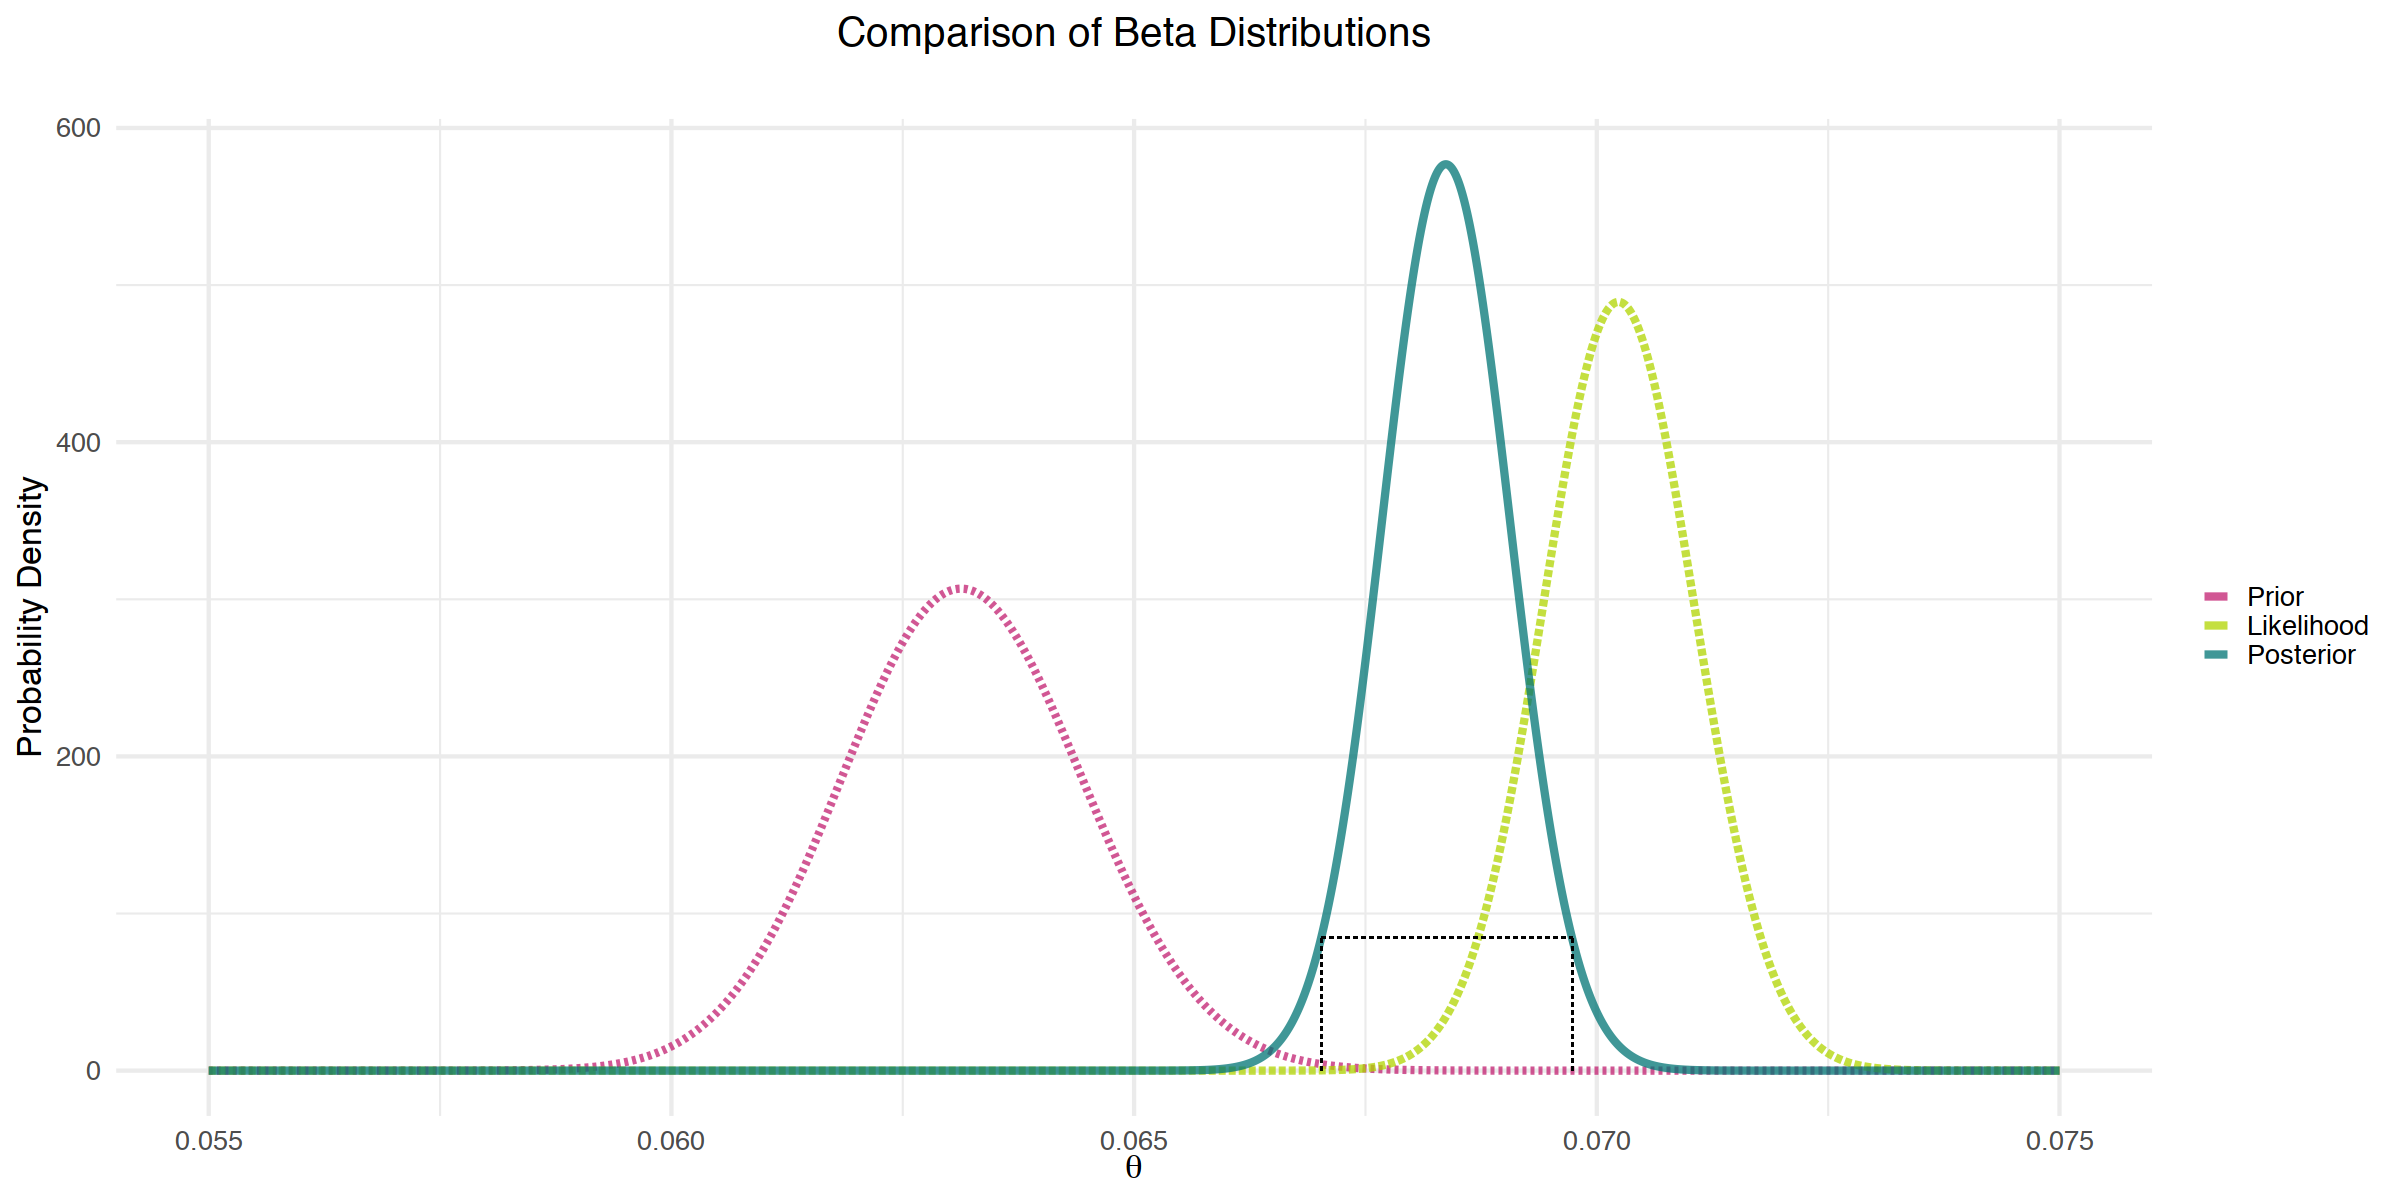

In [396]:
# Finally plot everything
# Change plot size
options(repr.plot.width=20, repr.plot.height=10)

# Plot
labels <- c("Prior", "Likelihood", "Posterior")
ggplot(dists, aes(x = thetas, y = value, group = variable, colour = variable, linetype = variable)) + 
    geom_line(size = 1.75, alpha = 0.75) +
    scale_linetype_manual(values = c("dashed","longdash","solid"), guide = F) + 
    scale_color_manual(values = c("#C21F70","#B0D400","#007575"), name = "", labels = labels) +
    labs(title = "Comparison of Beta Distributions", subtitle = "", x = bquote(theta), y = "Probability Density") +
    geom_segment(aes(x = hdi_post[1], y = 0.0, xend = hdi_post[1], yend = hdi_yend), linetype = "dashed", colour = 'black') +
    geom_segment(aes(x = hdi_post[2], y = 0.0, xend = hdi_post[2], yend = hdi_yend), linetype = "dashed", colour = 'black') + 
    geom_segment(aes(x = hdi_post[1], y = hdi_yend, xend = hdi_post[2], yend = hdi_yend), linetype = "dashed", colour = 'black') +
    theme_minimal(base_size = 20) + theme(plot.title = element_text(hjust = 0.5)) + theme(legend.title = element_blank())

## Bayesian Hypothesis Testing
Up to now we understand how prior and likelihood are used to estimate the posterior distribution of a parameter of interest. We also know how conjugate priors can be used in this context and why they are helpful if we want to estimate the posterior via an analytical solution. However, what's still missing is how a __group comparison in a Bayesian framework__ actually looks like and what things to consider when deciding to reject or accept a hypothesis. While there are other approaches out there we'll take a closer look at two key concepts in the sections below.

### Highest Density Interval (HDI)
A common type of scenario in an experiment is to compare $H0 = 0$ against $H1 \ne 0$. Now, a frequentist on the one hand rejects the null if a confidence interval (e.g. 95% CI) around the estimated parameter does not include 0 - not knowing which values are more likely than others. A Bayesian on the other hand uses the highest density interval (e.g. 95% HDI) of the posterior distribution. The HDI represents the __region of most credible values__ - thus informs us which values are __more likely__ than others. However, we __don't apply the same decision rule__ and simply reject $H0$ if it's not included among the 95% most credible parameter values. Instead, we need an additional concept called __region of practical equivalence__ (ROPE) around $H0$ which we use __in combination with the HDI__. The ROPE consist of all possible value that we consider to be equivalent for practical purposes. This is especially important when the alternative is framed as _non-zero effect_ because with only enough data being collected the null is eventually rejected - no matter how small an effect may be.

Please note, the HDI describes the range of most credible values, thus must not to be confused with an equally-tailed interval which is defined by lower/upper percentiles of the posterior. While they are the same for symmetric distributions they are fundamentally different when distributions are skewed.

### Region of Practical Equivalence (ROPE)
In addition to the HDI we use a ROPE around the null value in order to decide wether to reject or accept it. The ROPE defines a __narrow interval of values which we consider to be practically equivalent to the null value__ (e.g. zero difference between two groups). In an ideal world the size of the region reflects __the costs and the benefits__ of developing, testing, implementing and maintaining a variation as well as the ability to measure its effect. You should always ask yourself "_How much better does our variation have to  before we consider it a success?_" and "_How much worse do we allow our variation to be before we consider it a failure?_". Defining appropriate boundaries of the ROPE is therefore a case by case decision where narrower limits cause the null to be rejected more often and wider limits cause the null to be accepted more often. With a ROPE in place we can use the following __decision rules for accepting/rejecting__:
- If the ROPE completely excludes the 95% HDI, we __reject the ROPEd value__ because the 95% most credible values are not considered to be practically equivalent
- If the ROPE completely includes the 95% HDI, we __accept the ROPEd value__ because the 95% most credible values are considered to be practically equivalent
- If the ROPE and 95% HDI only partially overlap, we __remain undecided__ because some of the 95% most credible values are practically equivalent to the ROPEd value and some are not

There are a couple of this to keep in mind, when applying the above decision rules. For example if we decide to reject a ROPEd value we __only reject this particular value__ and not all values within that region. Also, whenever we accept a ROPEd value we only consider the most credible values to be practically equivalent to the null value, but __do not make any statements about its probability__. Finally, when not making a decision we simply acknowledge that so far collected observations are not yet sufficient for making a conclusion. Eventhough the decision rules invite to make compressed statements about the comparison of test and control groups in an A/B test we should __always include a summary of the full posterior distributions__ as well. Reporting parameters such as the mode (most credible value), the mean, the limits of a 95% HDI or information on where the null value (or basically any other value of interest) lies within the posterior are much more informative than simply rejecting/accepting an underlying hypothesis. Especially, in situations where HDI and ROPE partially overlap one can use a much more granular analysis to __agree on completely different decision rules__ than suggested above.

### Comparison of Binomial Distributions
In order to understand how both HDI and ROPE are used in an A/B test we look at a simple example of the __comparison of conversion rates__ i.e. means of two independent Binomial distributions. While we consider the data created above to be the observations of the control, we introduce another set of events which then reflect observations of the variation. Finally, comparing both groups requires to get an accurate __representation of each posterior__ distributions. One way to do this is to randomly __sample__ a large number of representative points from the posterior. In our case these are two Beta distributions.

First, we add some __toy data for the test group__. For simplicity, we use the same prior and its corresponding parameters $a$ and $\beta$ as used before.

In [13]:
# Create additional toy data for second samples (prior is same as for control)
y_test <- c(replicate(6695, 1), replicate(84096-6695, 0)) # used for observations of variation

print(paste0("Sample mean of oberservations used for likelihood of test: ",round(mean(y_test), 5)))

[1] "Sample mean of oberservations used for likelihood of test: 0.07961"


Next, we update the the parameters of the second posterior based on the test group's observations and then __draw $n$ samples__ from each of the posterior distributions.

In [14]:
# Define inputs to rbeta
samples <- 100000

# Sample from exact marginal posterior distributions
post_control = rbeta(n = samples, shape1 = alpha_post, shape2 = beta_post)
post_test = rbeta(n = samples, shape1 = alpha + sum(y_test == 1), shape2 = beta + sum(y_test == 0))

print(paste0("Posterior means - control: ", round(mean(post_control), 5), " test: ", round(mean(post_test), 5)))

[1] "Posterior means - control: 0.06837 test: 0.07477"


Only looking at the posterior means i.e. the conversion rates reveals a clear difference between the two groups. But is still __difference meaningful__? For his to decide we need to decide what meaningful means (to us). We do this by __defining the null value__ and its region of practical equivalence. In addition to this, we can think of another, more ambitious __comparison value__ which may not be used for a final decision, but rather represents a best case result.

In [15]:
# Set comparison value (e.g. H0 = 0)
h0 <- 0 # variation is equal to control

# Define ROPE (e.g. 1% worse/better than null)
rel_width <- 0.01 
half_rope <- mean(post_control) * (1+h0+rel_width) - mean(post_control)
rope <- c(0-half_rope, 0+half_rope)
print(paste0("Lower/upper ROPE: ", round(rope[1], 5), "; ", round(rope[2], 5)))

# Set additional comparison value (e.g. variation is at least 8% better than control)
rel_impr <- 0.08

[1] "Lower/upper ROPE: -0.00068; 0.00068"


Our comparison is based on the __differences of the two posterior distributions__. We compute this in the next step ...

In [16]:
# Parameter summary
diffs <- data.frame(diff = post_test - post_control)
diffs_mean <- mean(diffs$diff)
diffs_hdi <- hdi(diffs$diff)
diffs_density <- density(diffs$diff)
diffs_mode <- diffs_density$x[which.max(diffs_density$y)]

# Print summary
print(paste0("Summary of difference of posteriors:"))
print(paste0("Mean: ", round(diffs_mean, 5)))
print(paste0("Mode: ", round(diffs_mode, 5)))

[1] "Summary of difference of posteriors:"
[1] "Mean: 0.0064"
[1] "Mode: 0.00642"


... and then __summarize the results__. These are the hard facts for a decision if we need to decide wether both group means are different from each other or not.

In [17]:
# Calculate probabilities of true value being in rope
in_rope <- mean(diffs$diff > rope[1] & diffs$diff < rope[2]) * 100

# Calculate probabilities of value being greater/smaller than value
comparison_val <- mean(post_control) * (1+rel_impr) - mean(post_control)
prob_greater <- 100 * round(mean(diffs$diff > comparison_val), 4)
prob_smaller <- 100 - prob_greater
comparison_label <- paste0(prob_smaller,"% < ",round(comparison_val,4)," < ",prob_greater,"%")

# Return summary
print(paste0("H0: Difference between the two groups is equal to ", h0, "."))
print(paste0("Lower/upper ROPE: ", round(rope[1], 5), "; ", round(rope[2], 5)))
print(paste0("Probability of difference of means being in ROPE: ", round(in_rope, 5), "%"))
print(paste0("Difference of means: ", round(diffs_mean, 5)))
print(paste0("Lower/upper 95% HDI: ", round(diffs_hdi[1], 5), "; ", round(diffs_hdi[2], 5)))
print(paste0("Comparison value: ", round(comparison_val, 5)))
print(paste0("Probability of difference of means being smaller/greater than comparison value: ", comparison_label))

[1] "H0: Difference between the two groups is equal to 0."
[1] "Lower/upper ROPE: -0.00068; 0.00068"
[1] "Probability of difference of means being in ROPE: 0%"
[1] "Difference of means: 0.0064"
[1] "Lower/upper 95% HDI: 0.00441; 0.00844"
[1] "Comparison value: 0.00547"
[1] "Probability of difference of means being smaller/greater than comparison value: 18.32% < 0.0055 < 81.68%"


Turning back the the __decision rules__ outlined above, we can reject $H0$ because the 95% HDI completely excludes the ROPE. This means 95% of all values are not considered practically equivalent to the null value. Despite that, with 82.01% we see a high probability of the difference between the two groups being greater than the much more ambitious comparison value. Again - and this is important - we can only make such statements because we work in a Bayesian framework. In frequentist hypothesis testing we wouldn't know which value was more or less likely than another.

For sure we can make the summary of the comparison a bit more appealing ...

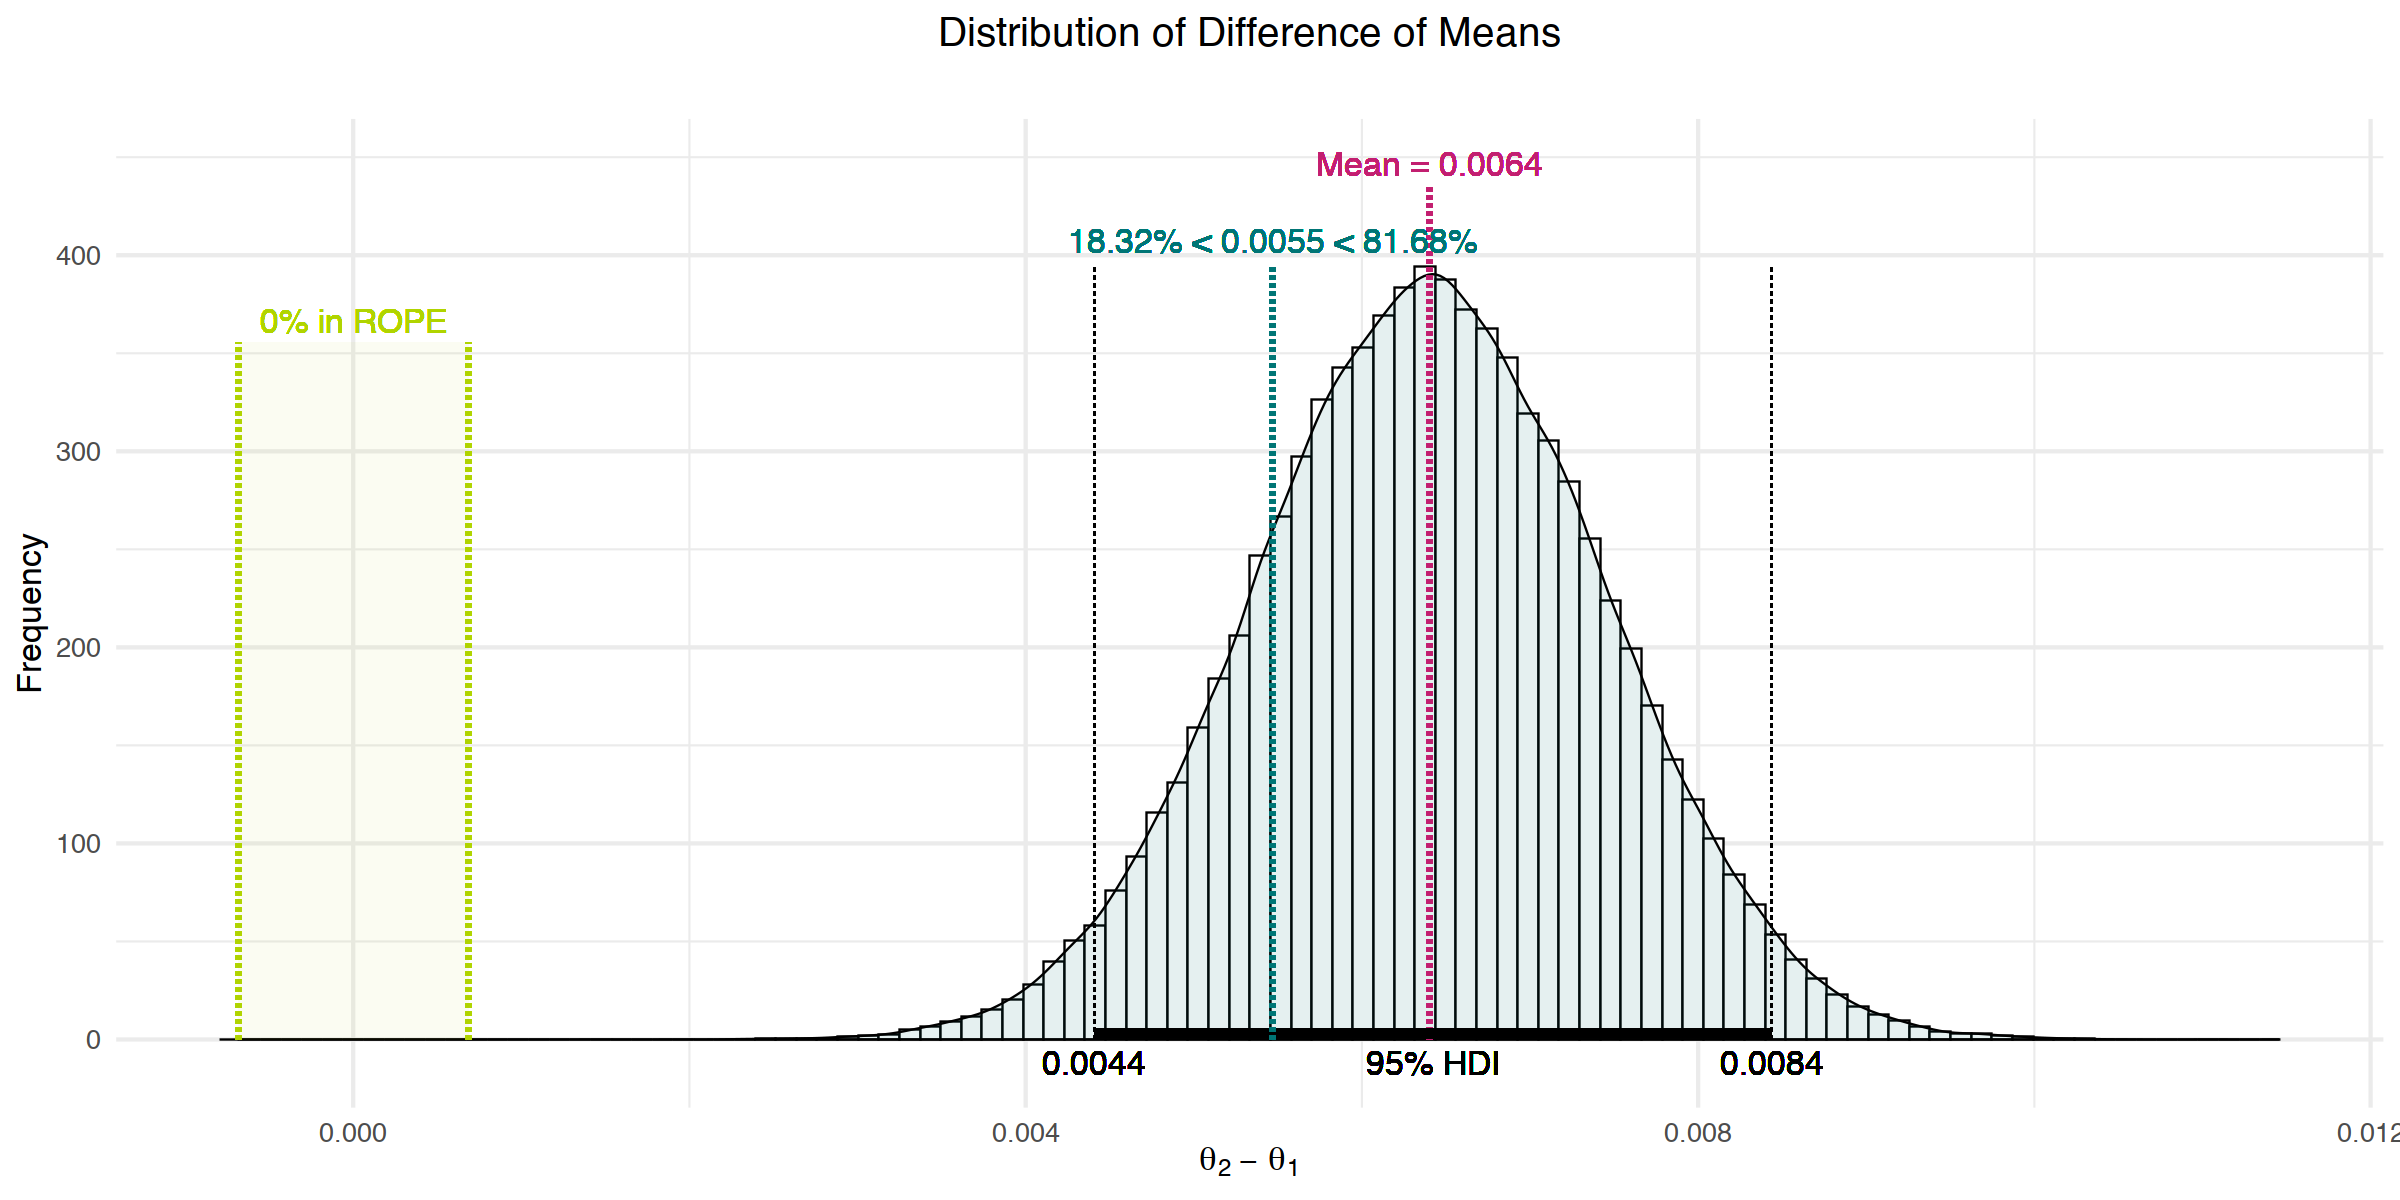

In [19]:
# Plot histogram (may take a while of number of samples is large)
title = "Distribution of Difference of Means"
xlab = expression(theta[2]~-~~theta[1])
plot_histogram(diffs, title = title, comparison_value = comparison_val, rope = rope, xlab = xlab)

In this section we've seen how we can use __Bayesian inference in the context of hypothesis testing__. Because our example included two Binomial likelihoods which have a conjugate prior distribution we were able to sample a large number of estimates from each marginal posterior directly. By applying both concepts, HDI and ROPE, we've used both of the samples to compare the two groups based on the difference of means. Despite making a decision on accepting/rejecting the null hypothesis only, we saw that the full posterior allows for much more granular analysess and even statements about the probability of individual comparison values. Unfortunately, not all likelihoods have conjugate priors and not all posterior distributions have simple forms and low dimensions. And if this is the case we can't use an analytical solution ...

### Markov Chain Monte Carlo (MCMC)
If we cannot sample from the posterior directly or the underlying model is too complex (e.g. large number of unknown parameters) and sampling is difficult, we can use Markov Chain Monte Carlo (MCMC) methods to approximate exact values - and the more samples we generate, the more accurate the approximation. While there are many MCMC variants out there we look at one of them in this notebook more closely: the __Metropolis-Hastings__ algorithm. Starting off from an arbitrary point, the algorithm iteratively __moves across the parameter space__ of the posterior i.e. target distribution with each next move only being dependent on the previous move. As the goal is to find those values of the target distribution which are more likely than others the algorithm tends to accept individual moves only if they lead to higher density regions. By doing so it generates samples which follow the distribution of interest i.e. the target distribution. Before putting this in code and making it more clear and intuitive, we take a look at the __requirements__ of Metropolis-Hastings algorithm. More specifically, the Metropolis-Hastings algorithm with symmetric proposal distribution:
1. Ability to __specify proposal distribution__ to propose a new value $\theta_{prop}$, based on current value $\theta_{curr}$
    - The proposal distribution suggests the algorithm where to move and a common choice for the proposal represents the Normal distribution.
2. Ability to __evaluate target distribution__ at any proposed value, to compute $P(\theta_{prop})/P(\theta_{curr})$
    - The target distribution is given by the product of prior and likelihood (which need to be specified) instead of full Bayes formula. That's simply because if we calculate one probability over the other the difficult to compute term $P(D)$ is cancelled out.
3. Ability to generate random value from uniform distribution, to __accept or reject the proposal__
    - More specifically, while moves to values being more likely then the previous one are always accepted, moves to values being less likely are accepted probabilistically only.


The algorithm itself then proceeds as follows:
1. __Choose arbitrary point__ $\theta_{curr}$ in parameter space of target distribution.
2. __Repeat__ until sufficiently representative sample is generated:
    - Propose a new move/value based on current value $\theta_{prop}$~$Normal(\theta_{curr},\sigma)$.
    - Compute probability of moving to proposed value $p_{move} = min(1, P(\theta_{prop})/P(\theta_{curr}))$. In situations where the proposed value is outside the allowed bounds of prior or likelihood $p_{move}$ is set to zero.
    - Accept move if random value $x < p_{move}$ with $x$~$Uniform(0,1)$, otherwise remain at current position

#### Example: Single Sample
Before using the Metropolis-Hastings algorithm in an A/B testing example, where we compare two different groups with each other, we __illustrate how the procedure works__ on a single sample. As we are already familiar with Beta priors and Binomial likelihoods we do so by building upon the previous examples. Eventhough we wouldn't use MCMC methods when conjugate priors exist in real life, working with a simple example helps to focus on the algorithm itself rather than worrying about complex distributions.

Below we define the algorithm for a single sample as a function. The required inputs are:
- ```y```, Vector of __observations__ (in example vector of 0s and 1s for unsuccessful and successful conversion)
- ```alpha```: Non-negative __parameter of beta distribution__
- ```beta```: Non-negative __parameter of beta distribution__
- ```samples```: Number of __iterations__
- ```burnin```: Fraction of __iterations to discard__ from beginning of chain. Dependent on the value for ```theta_init``` the samples generated by the chain can be far off of the mass of the target distribution and this paramter is used to throw away likely unrepresentative values among the first iterations.
- ```theta_init```: Arbitrary __starting value__ for $\theta$ in parameter space of target distribution
- ```sd_init```: Standard deviation of __proposal function__ $Normal(\theta_{curr},\sigma)$. This is a case by case decision and needs to be tuned to achieve an acceptance rate of 30-40% (sources differ). In general, decrease value to lower acceptance rate (smaller steps) and increase value to increase acceptance rate (bigger steps). More details on the accpetance rate and how to calculate it is covered at the end of this notebook.
- ```seed```: Set seed for __reproducible results__ (optional)

In [20]:
# Function for random walk Metropolis-Hastings sampler for single parameter theta. Source:
# - https://www.casact.org/library/studynotes/MASII_mcmc_algorithms_v0.5.pdf
# - http://www.r-5.org/files/books/computers/algo-list/statistics/data-mining/John_K_Kruschke-Doing_Bayesian_Data_Analysis-EN.pdf
# - https://github.com/boboppie/kruschke-doing_bayesian_data_analysis/tree/master/2e

metropolis_1d_mcmc <- function(y, alpha = 1, beta = 1, samples = 1000, burnin = 0.1, theta_init = 0.1, sd_init = 0.05, seed=NULL){ 
    
    # Check inputs 
    if (is.null(y)){
        stop('Please provide observations ...')
    }
    z1 <- sum(y == 1)
    N1 <- length(y)
    
    # Define functions
    
    # Define binomial log-likelihood function: P(data|theta)
    log_llh <- function(theta, z=z1, N=N1) {
        # Estimates log-likelihood of binomial distribution
        #
        # Args:
        # - theta: Probability of success, generated at random
        # - z: Number of successes in input vector y
        # - N: Number of observations in input vector y
        #
        # Returns:
        # - llh: Log-likelihood
        #

        return(dbinom(x = z, size = N, prob = theta, log = T))
    }

    # Define beta log-likelihood function
    log_prior <- function(theta, shape1 = alpha, shape2 = beta) {
        # Estimates log-likelihood of prior distribution:
        # Beta distribution as conjugate prior for binomial distribution
        #
        # Args:
        # - theta: Probability of success, generated at random
        # - shape1, shape2: Non-negative parameters of beta distribution
        #
        # Returns:
        # - Log-likelihood of prior

        return(dbeta(theta, shape1 = shape1, shape2 = shape2, log = T))
    }
    
    # Define function for relative probabilities of
    # target distribution / posterior
    log_posterior <- function(theta) {
        # Estimates log-likelihood of prior distribution:
        # Beta distribution as conjugate prior for binomial distribution
        #
        # Args:
        # - theta: Probability of success, generated at random
        # - data: Vector with data for single sample
        # - shape1, shape2: Non-negative parameters of beta distribution
        #
        # Returns:
        # - Log-likelihood of posterior
        return(log_llh(theta) + log_prior(theta))
    }
    
    # Create vector of NAs to store sampled parameters
    chain <- array(dim = c(samples+1,1))
    chain[1,] <- theta_init
    
    # Define burn-in (e.g. drop first 10% of thetas)
    burnin = ceiling(burnin * samples)
    
    # Set seed and run chains
    if(!is.null(seed)){set.seed(seed)}
    
    for (i in 1:samples) {
        
        # Proposed theta centered at current value: If proposed parameter is
        # outside its range keep its current value, otherwise keep the
        # proposed value. That's simply because likelihood for theta > 1
        # or for theta < 0 is zero
        theta_prop <- rnorm(n = 1, mean = chain[i,], sd = sd_init)
        theta_prop <- ifelse((theta_prop < 0 | theta_prop > 1), chain[i,], theta_prop)
        
        # Calculate probability of accepting new value of theta
        prob_accept <- min(1.0, exp(log_posterior(theta_prop) - log_posterior(chain[i,])))
        
        # Generate a random uniform value from the interval [0,1] to
        # decide whether or not to accept the proposed theta
        chain[i+1,] <- ifelse(runif(1) < prob_accept, theta_prop, chain[i,])
        
    }
    
    # Return trimmed chain without burn-in values
    return(chain[-(1:burnin),])
}

We __run the chain__ to approximate the posterior distribution with the same parameters as above despite additionally specifying the standard deviation of the target distribution. In detail this means that ```y``` represents the observations from the control and ```alpha``` and ```beta``` are the shape parameters we've previously used for the prior. Also, as ```theta_init``` (which represents the posterior conversion rate in the example) is an arbitrary starting value, we don't worry about it at the moment, but simply go with its default as stated in the function.

In [21]:
# Define remaining inputs
sd_init <- 0.0025

# Run metropolis sampler
chain <- metropolis_1d_mcmc(y_control, alpha = alpha, beta = beta, samples = samples, sd_init = sd_init)

We can use the samples generated by the chain to calculate different __summary statistics__ of interest ...

In [22]:
# Parameter summary of chain
chain_density <- density(chain)
chain_mode <- chain_density$x[which.max(chain_density$y)]
chain_mean <- mean(chain)
chain_sd <- sd(chain)
chain_hdi <- hdi(chain)

# Compute alpha and beta for beta distribution that has the same mean
# and standard deviation as the sample from the posterior:
# -> These could be used as inouts to prior for the next analyses.
chain_alpha <- chain_mean * ((chain_mean * (1-chain_mean) / chain_sd^2) - 1)
chain_beta <- (1-chain_mean) * ((chain_mean * (1-chain_mean) / chain_sd^2) - 1)

# Print summary of chain
print(paste0("MCMC summary of posterior:"))
print(paste0("Mean: ", round(chain_mean, 5)))
print(paste0("Mode: ", round(chain_mode, 5)))

[1] "MCMC summary of posterior:"
[1] "Mean: 0.06837"
[1] "Mode: 0.06836"


... and/or create a __visiual summary__ of the results (as before).

In [23]:
# Store chain in data frame for ggplot histogram
chain_df <- data.frame(chain = chain)

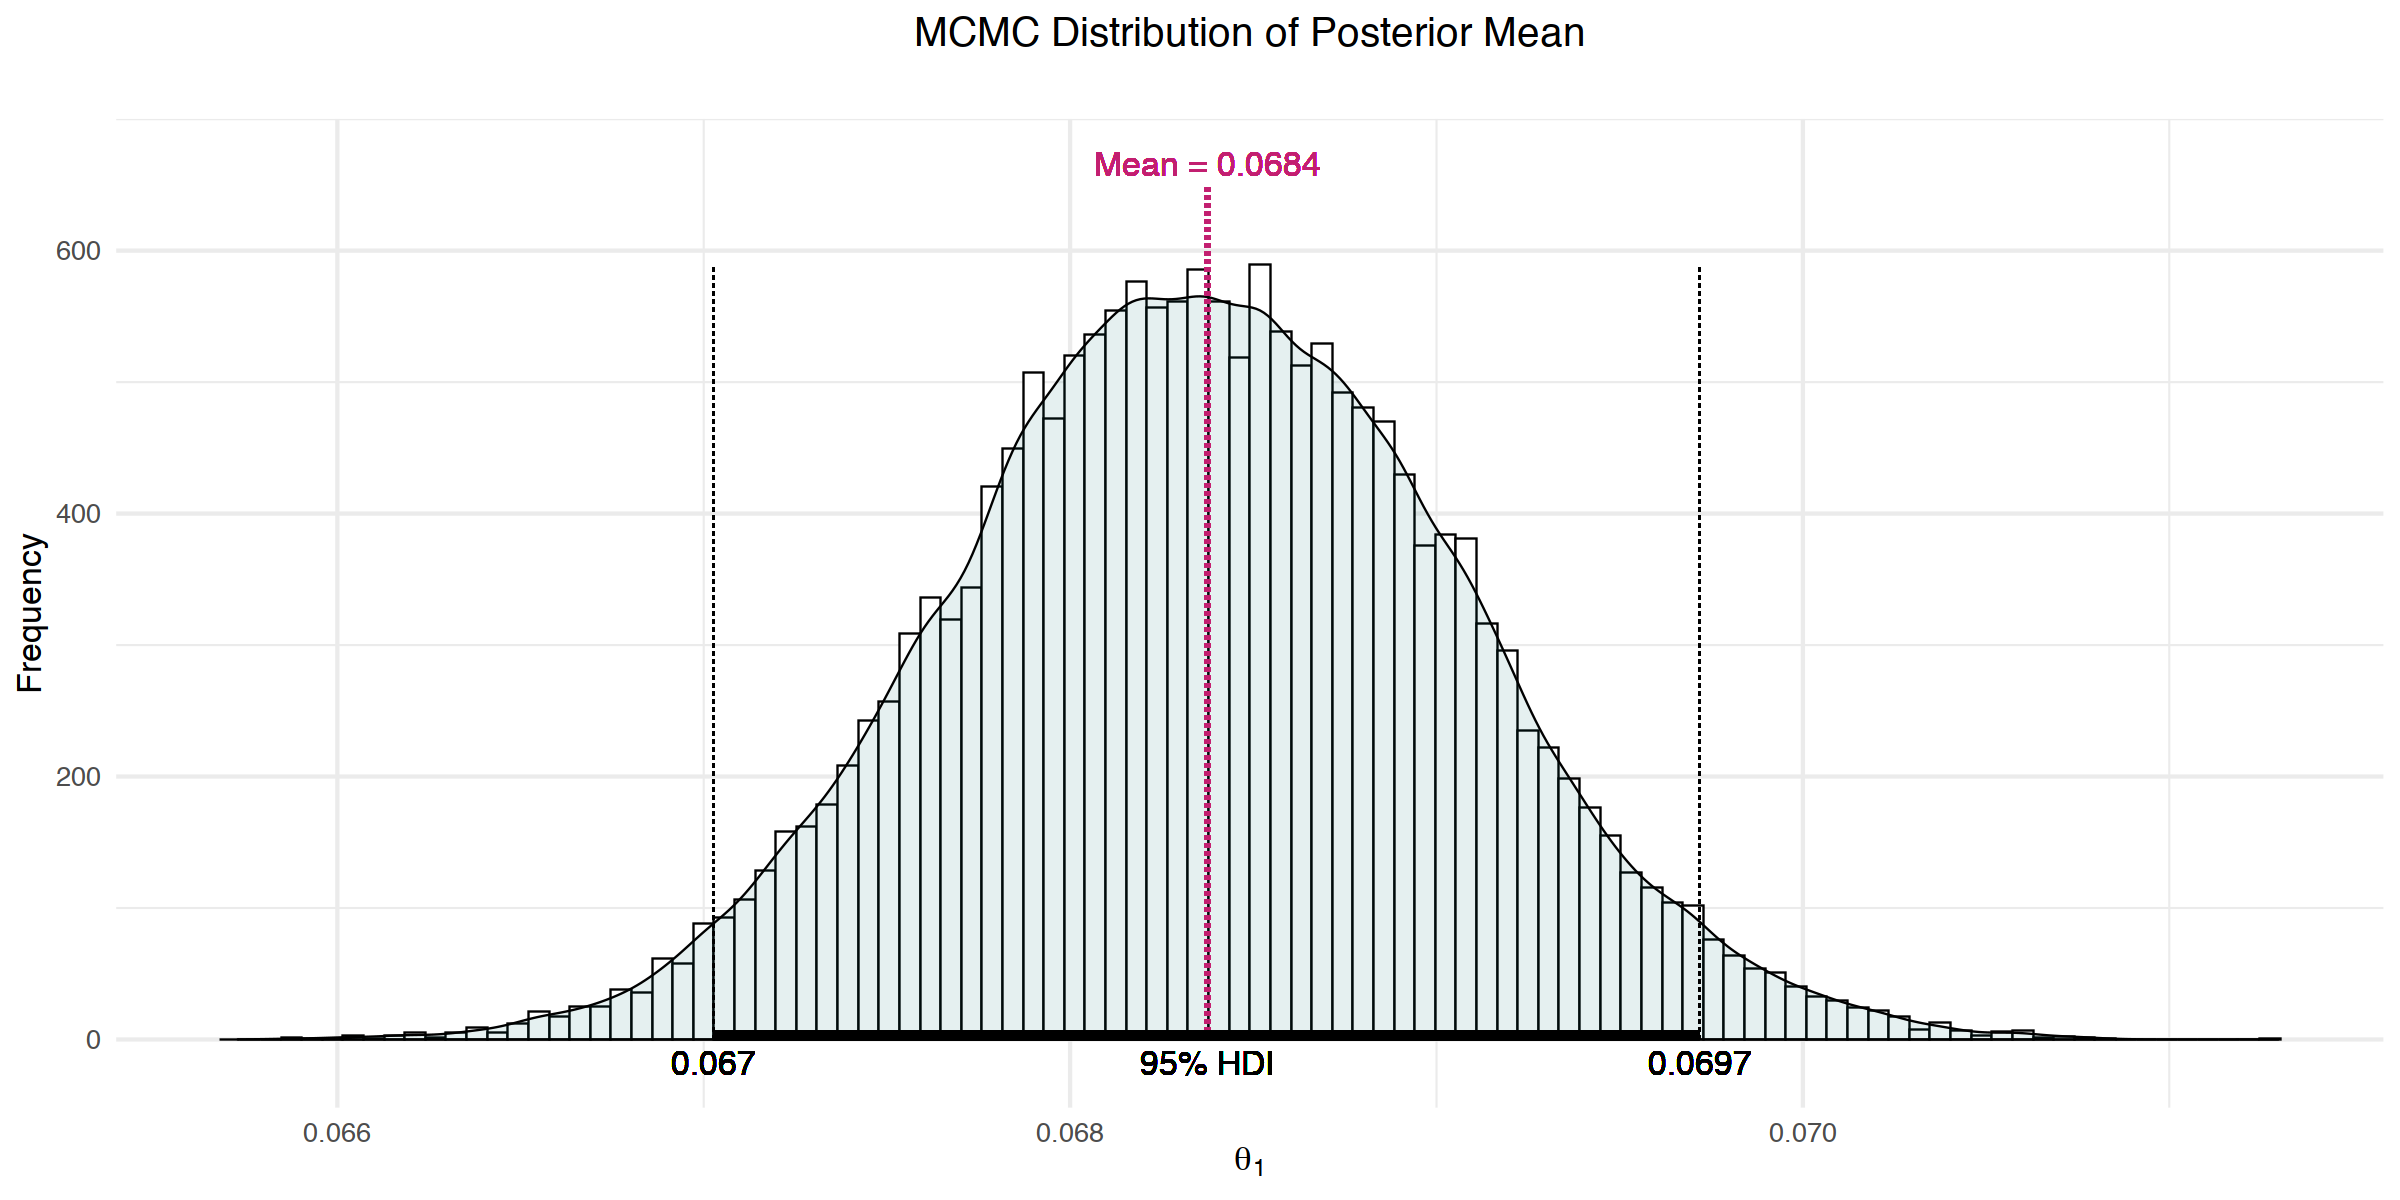

In [24]:
# Plot histogram of single chain
title = "MCMC Distribution of Posterior Mean"
plot_histogram(chain_df, title)

Finally, when comparing mean and mode of both __analytically derived and MCMC posterior__ we see that they are __nearly identical__. However, let's jump straight to the A/B testing i.e. two sample example.

#### Example: Two Samples

Having a basic understanding of how the Metropolis-Hastings algorithm works we now turn towards the application of MCMC to the comparison of two groups in an A/B test. Again, we keep things simple and stick to the previous example of two independent Binomial distributions. The function for the two dimensional Metroplis-Hastings algorithm is similar to the one before, except:
- Inputs are now provided as __vectors and matrices__. More precisely, while shape parameters for priors and starting values of $\theta$ are provided as vectors, the standard deviation $\sigma$ of the proposal distribution is substituted by a covariance matrix to account for a multi-variate case. By setting off-diagonal elements to zero we also make sure that draws from the proposal are independent.
- Prior, likelihood and posterior account for __independence of comparison groups__ i.e. samples. Mathematically, independence means that $P(\theta_{1},\theta_{2}) = P(\theta_{1})P(\theta_{2})$ for every value of $\theta_{1}$ and $\theta_{2}$, where $P(\theta_{1})$ and $P(\theta_{2})$ are the marginal distributions of each group.

Below we can see what the adjusted function now looks like.

In [25]:
# Function for random walk Metropolis-Hastings sampler in two dimensions. Source:
# - https://www.casact.org/library/studynotes/MASII_mcmc_algorithms_v0.5.pdf
# - http://www.r-5.org/files/books/computers/algo-list/statistics/data-mining/John_K_Kruschke-Doing_Bayesian_Data_Analysis-EN.pdf
# - https://github.com/boboppie/kruschke-doing_bayesian_data_analysis/blob/master/1e/BernTwoMetropolis.R

metropolis_2d_mcmc <- function(y1, y2, alpha = c(1,1), beta = c(1,1), samples = 1000, burnin = 0.1, theta_init = c(0.5,0.5), cov_mat = NULL, seed = NULL){ 
    
    # Check inputs 
    if (any(is.null(y1),is.null(y2))){
        stop('Please provide observations ...')
    }
    z1 <- sum(y1 == 1)
    N1 <- length(y1)
    z2 <- sum(y2 == 1)
    N2 <- length(y2)

    # Define functions
    
    # Define joint binomial log-likelihood function: P(data|theta)
    log_llh <- function(theta, z=c(z1,z2), N=c(N1,N2)) {
        # Estimates log-likelihood of binomial distribution
        #
        # Args:
        # - theta: Probability of success, generated at random
        # - z: Number of successes in input vectors y1 and y2
        # - N: Number of observations in input vector y1 and y2
        #
        # Returns:
        # - llh: Log-likelihood

        return(dbinom(x = z[1], size = N[1], prob = theta[1], log = T) + 
               dbinom(x = z[2], size = N[2], prob = theta[2], log = T))
    }

    # Define joint beta log-likelihood function
    log_prior <- function(theta, shape1 = alpha, shape2 = beta) {
        # Estimates log-likelihood of prior distribution:
        # Beta distribution as conjugate prior for binomial distribution
        #
        # Args:
        # - theta: Probability of success, generated at random
        # - shape1, shape2: Vectors of non-negative parameters of beta distribution
        #
        # Returns:
        # - Log-likelihood of prior
        
        return(dbeta(theta[1], shape1 = shape1[1], shape2 = shape2[1], log = T) + 
               dbeta(theta[2], shape1 = shape1[2], shape2 = shape2[2], log = T))
    }
    
    # Define function for relative probabilities of
    # target distribution / posterior
    log_posterior <- function(theta) {
        # Estimates log-likelihood of prior distribution:
        # Beta distribution as conjugate prior for binomial distribution
        #
        # Args:
        # - theta: Probability of success, generated at random
        # - data: Vector with data for single sample
        # - shape1, shape2: Non-negative parameters of beta distribution
        #
        # Returns:
        # - Log-likelihood of posterior
        
        return(log_prior(theta) + log_llh(theta))
    }
    
    # Create vector of NAs to store sampled parameters
    chain <- matrix(NA, nrow = samples+1, ncol = 2)
    chain[1,] <- theta_init
    
    # Define burn-in (e.g. drop first 10% of thetas)
    burnin = ceiling(burnin * samples)
    
    # Set seed and run chains
    if(!is.null(seed)){set.seed(seed)}
    
    for (i in 1:samples) {
        
        # Proposed thetas centered at current values
        theta_curr <- chain[i,]
        theta_prop <- mvrnorm(n = 1, mu = theta_curr, Sigma = cov_mat)
        
        # If any of the proposed parameters is outside its range
        # keep its current value, otherwise keep the proposed value
        # That's simply because likelihood for theta > 1 or for
        # theta < 0 is zero
        theta_prop <- mapply(FUN = function(x,y) ifelse((x > 1 | x < 0), y, x), x = theta_prop, y = chain[i,])
                             
        # Calculate joint probability of accepting new value of theta
        prob_accept <- min(1.0, exp(log_posterior(theta_prop) - log_posterior(theta_curr)))
        
        # Generate a random uniform value from the interval [0,1] to
        # decide whether or not to accept the proposed thetas
        if(runif(1) < prob_accept){
            chain[i+1,] <- theta_prop
        } else {
            chain[i+1,] <- theta_curr
        }
    }
    
    # Return trimmed chain without burn-in values
    return(chain[-(1:burnin),])
}

We use the same inputs as above when available and define the missing inputs before we __run the chains__. Again, we do use the same prior for both test and control group and add an additional covariance matrix for the multivariate Normal proposal distribution.

In [26]:
# Define missing inputs
sd1 <- 0.0015
sd2 <- 0.0015
cov_mat <- matrix(c(sd1^2, 0.00, 0.00, sd2^2), nrow = 2, ncol = 2)

# Run metropolis sampler
chain <- metropolis_2d_mcmc(y_control, y_test, alpha = c(alpha,alpha), beta = c(beta,beta), samples = samples, cov_mat = cov_mat)

Finally, we can create a __summary of each chain__ ...

In [27]:
# Parameter summary of chain
chain_density <- apply(chain, 2, density)
chain_mode <- lapply(chain_density, function(d) d$x[which.max(d$y)])
chain_mean <- apply(chain, 2, mean)
chain_sd <- apply(chain, 2, sd)
chain_hdi <- apply(chain, 2, hdi)

# Compute alpha and beta for beta distribution that has the same mean
# and standard deviation as the sample from the posterior:
# -> These could be used as inouts to prior for the next analyses.
chain_alpha <- chain_mean * ((chain_mean * (1-chain_mean) / chain_sd^2) - 1)
chain_beta <- (1-chain_mean) * ((chain_mean * (1-chain_mean) / chain_sd^2) - 1)
                    
# Store chain in data frame for ggplot histogram
chain_df <- data.frame(chain)
                     
# Print summary of chain
print(paste0("MCMC summary of posterior:"))
print(paste0("Mean - control: ", round(chain_mean[[1]], 5), " test: ", round(chain_mean[[2]], 5)))
print(paste0("Mode - control: ", round(chain_mode[[1]], 5), " test: ", round(chain_mode[[2]], 5)))

[1] "MCMC summary of posterior:"
[1] "Mean - control: 0.06838 test: 0.0748"
[1] "Mode - control: 0.06835 test: 0.07467"


... before making __inference__ on the difference between both groups. For this we can create an additional summary ...

In [31]:
# Generate summary statistics for difference of means
diffs <- data.frame(diff = chain[,2] - chain[,1])
diffs_mean <- mean(diffs$diff)
diffs_sd <- sd(diffs$diff) 
diffs_hdi <- hdi(diffs$diff)
diffs_density <- density(diffs$diff)
diffs_mode <- diffs_density$x[which.max(diffs_density$y)]

# Print summary
print(paste0("Summary of difference of posteriors:"))
print(paste0("Mean: ", round(diffs_mean, 5)))
print(paste0("Mode: ", round(diffs_mode, 5)))

[1] "Summary of difference of posteriors:"
[1] "Mean: 0.00643"
[1] "Mode: 0.00651"


In [32]:
# Calculate probabilities of true value being in rope
in_rope <- mean(diffs$diff > rope[1] & diffs$diff < rope[2]) * 100

# Calculate probabilities of value being greater/smaller than value
comparison_val <- mean(chain[,1]) * (1+rel_impr) - mean(chain[,1])
prob_greater <- 100 * round(mean(diffs$diff > comparison_val), 4)
prob_smaller <- 100 - prob_greater
comparison_label <- paste0(prob_smaller,"% < ",round(comparison_val,4)," < ",prob_greater,"%")

# Return summary
print(paste0("H0: Difference between the two groups is equal to ", h0, "."))
print(paste0("Lower/upper ROPE: ", round(rope[1], 5), "; ", round(rope[2], 5)))
print(paste0("Probability of difference of means being in ROPE: ", round(in_rope, 5), "%"))
print(paste0("Difference of means: ", round(diffs_mean, 5)))
print(paste0("Lower/upper 95% HDI: ", round(diffs_hdi[1], 5), "; ", round(diffs_hdi[2], 5)))
print(paste0("Comparison value: ", round(comparison_val, 5)))
print(paste0("Probability of difference of means being smaller/greater than comparison value: ", comparison_label))

[1] "H0: Difference between the two groups is equal to 0."
[1] "Lower/upper ROPE: -0.00068; 0.00068"
[1] "Probability of difference of means being in ROPE: 0%"
[1] "Difference of means: 0.00643"
[1] "Lower/upper 95% HDI: 0.0044; 0.00842"
[1] "Comparison value: 0.00547"
[1] "Probability of difference of means being smaller/greater than comparison value: 18.03% < 0.0055 < 81.97%"


... and a final __plot of the relevant results__.

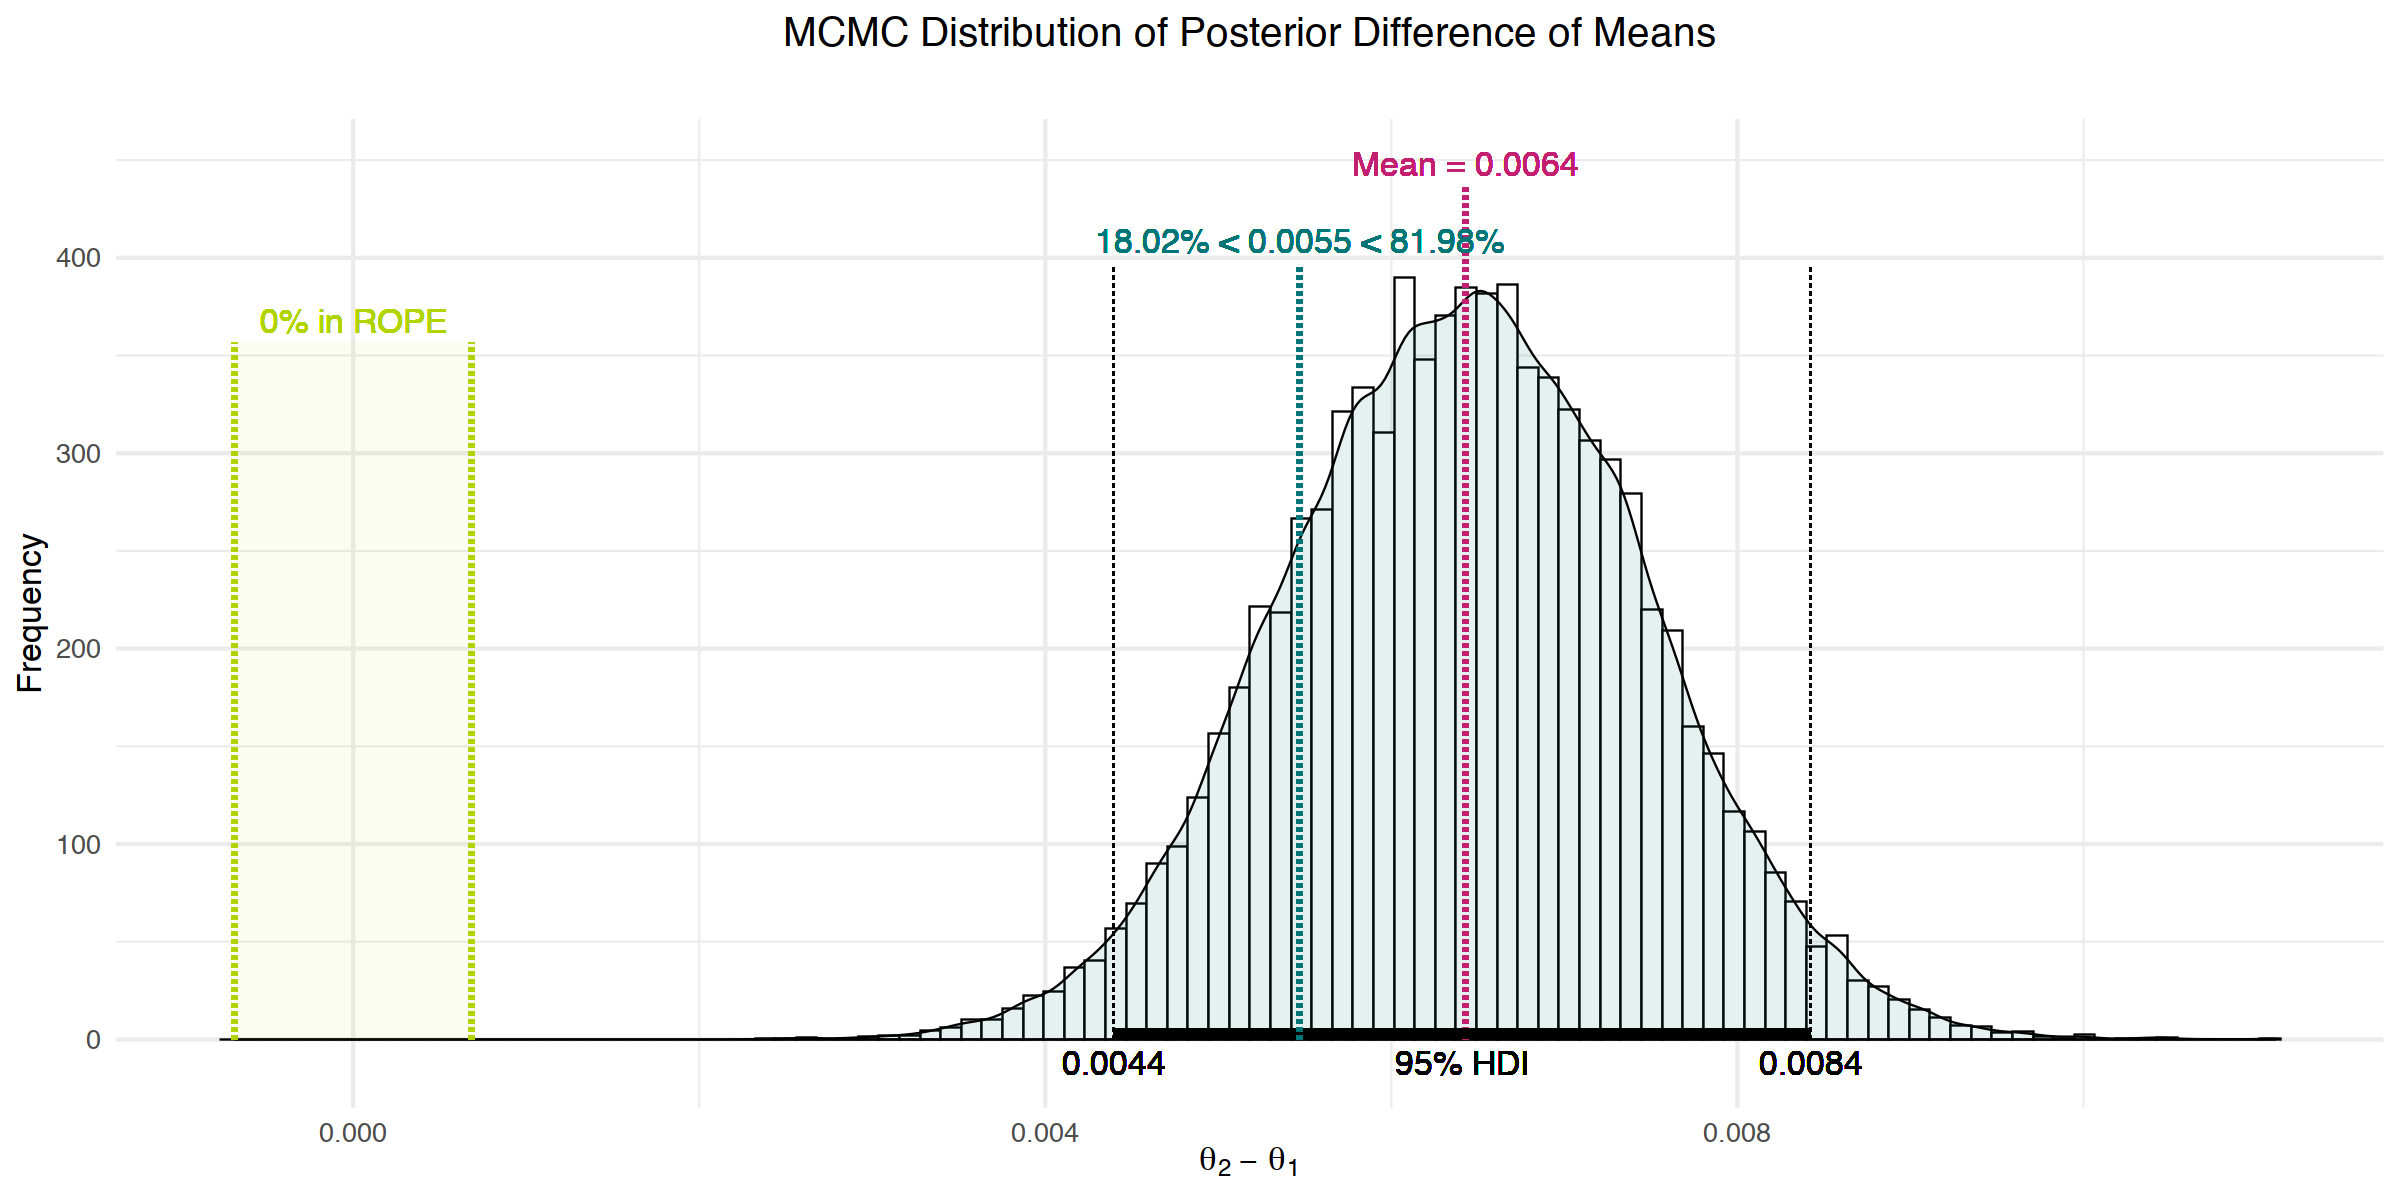

In [29]:
# Define new comparison value based on posterior of control
val <- mean(chain[,1]) * (1+h0) - mean(chain[,1]) 

# Plot histogram
title = "MCMC Distribution of Posterior Difference of Means"
xlab = expression(theta[2]~-~~theta[1])
plot_histogram(diffs, title = title, comparison_value = comparison_val, rope = rope, xlab = xlab)

Summary as well as plot reveal that also the two dimensional __MCMC works__. The algorithm is able to produce samples which are nearly identical to the exact solution. The advantage of having an exact solution for comparison is that we can do additional analyses on the similarity of both distributions such as the comparison of quantiles.

In [25]:
# Number of samples to draw from the exact marginal posterior
# distributions (equal to the length of our chain post burnin)
n <- nrow(chain)

# Random samples from marginal distributions
theta_1_exact <- rbeta(n = n, shape1 = alpha + sum(y_control == 1), shape2 = beta + sum(y_control == 0))
theta_2_exact <- rbeta(n = n, shape1 = alpha + sum(y_test == 1), shape2 = beta + sum(y_test == 0))

# Posteriro from MCMC 
theta_1_apprx <- chain[ ,1]
theta_2_apprx <- chain[ ,2]

# Add to matrix
thetas <- cbind(theta_1_exact, theta_1_apprx, theta_2_exact, theta_2_apprx)

# Compare quantiles
quantiles <- apply(thetas, 2, FUN = quantile, c(0.025, 0.05, 0.25, 0.5 ,0.75, 0.95, 0.975))
quantiles

,theta_1_exact,theta_1_apprx,theta_2_exact,theta_2_apprx
2.5%,0.06703457,0.06703933,0.07329059,0.07328003
5%,0.06724641,0.06724424,0.07353038,0.07352029
25%,0.06790786,0.06792269,0.07426058,0.07425048
50%,0.06837349,0.06837530,0.07477175,0.07476426
75%,0.06884233,0.06883004,0.07528190,0.07528641
95%,0.06951449,0.06949419,0.07603396,0.07602506
97.5%,0.06973597,0.06972012,0.07627262,0.07626925


### MCMC Diagnostics
When we use MCMC we usually don't have conjugate priors for the likelihood and consequently don't have an analytical solution to the posterior distribution. Therefore, we need other means for the evaluation of the chain. More specifically, we want to evaluate if the chain was able to generated __sufficiently representative__ samples. In order to do so we look at three different measures in the following section:
- Trace Plots
- Potential Scale Reduction Factor (PSRF)
- Acceptance Rate

Source: https://www.casact.org/library/studynotes/MASII_mcmc_algorithms_v0.5.pdf
Tips for optimization: http://www.life.illinois.edu/dietze/Lectures2012/Lesson12_Metropolis.pdf

#### Trace Plots

Trace plots represent a visual technique for assessing the convergence of indiviual chains. The idea is to run two or more chains with different initializations in order to observe if they __converge towards the same stationary target distribution__. Seeing all chains mixing irrespective of their starting value is a first indication of representative posterior distributions.

First, we run the chain with different values for ```theta_init```...

In [33]:
# Re-run chain with different initializations and without burnin period
# in order to observe convergence

# Define inputs
samples <- 10000
theta_init <- c(0.01, 0.025, 0.05, 0.075, 0.10, 0.15)
sd_init <- 0.0025

# Create data frame to store chains
chains <- data.frame(matrix(NA, nrow = samples, ncol = length(theta_init)))
names(chains) <- as.character(theta_init)
chains$step <- seq(1, nrow(chains), 1)

# Run chains
for (i in 1:length(theta_init)){
    chains[,i] <- metropolis_1d_mcmc(
        y_control,
        alpha = alpha, beta = beta,
        samples = samples,
        theta_init = theta_init[i], sd_init = sd_init,
        burnin = 0.0)
}

In [35]:
# Preview chains
head(chains)

# Melt for plotting
melted_chains <- melt(chains, id.vars = "step")

,0.01,0.025,0.05,0.075,0.1,0.15,step
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.01191664,0.02500000,0.05000000,0.07500000,0.10000000,0.1471215,1
2,0.01191664,0.02500000,0.05197002,0.07500000,0.10000000,0.1434485,2
3,0.01191664,0.02500000,0.05197002,0.07500000,0.09628905,0.1432180,3
4,0.01437697,0.02500000,0.05313918,0.07468395,0.09556737,0.1408586,4
5,0.01527871,0.02839159,0.05313918,0.07468395,0.09556737,0.1408586,5
6,0.01978533,0.03063171,0.05313918,0.07468395,0.09556737,0.1408586,6


... and then create two plots to asses each chains convergence. One for the beginning of the chains and one for their end.

In [36]:
# Change plot size
options(repr.plot.width=24, repr.plot.height=8)

# Plot
trace_plot_start <- ggplot(melted_chains[melted_chains$step <= 200, ], aes(x = step, y = value, group = variable, colour = variable, linetype = variable)) + 
    geom_line(size = 1., alpha = 0.75) +
    scale_linetype_manual(values = rep("solid", length(theta_init)), guide = F) +
    scale_color_manual(values = c("#B0D400", "#007575", "#C21F70", "#577080", "#FFA000", "#333333"), name = "Initial Theta") +
    labs(title = "MCMC Trace Plots Before Convergence", subtitle = "", x = "Step", y = bquote(theta)) +
    theme_minimal(base_size = 20) + theme(plot.title = element_text(hjust = 0.5))

In [37]:
# Trace plot past convergence
trace_plot_end <- ggplot(melted_chains[melted_chains$step > 200, ], aes(x = step, y = value, group = variable, colour = variable, linetype = variable)) + 
    geom_line(size = 1., alpha = 0.75) +
    ylim(0.06, 0.08) + 
    scale_linetype_manual(values = rep("solid", length(theta_init)), guide = F) +
    scale_color_manual(values = c("#B0D400", "#007575", "#C21F70", "#577080", "#FFA000", "#333333"), name = "Initial Theta") +
    labs(title = "MCMC Trace Plots After Convergence", subtitle = "", x = "Step", y = bquote(theta)) +
    theme_minimal(base_size = 20) + theme(plot.title = element_text(hjust = 0.5))

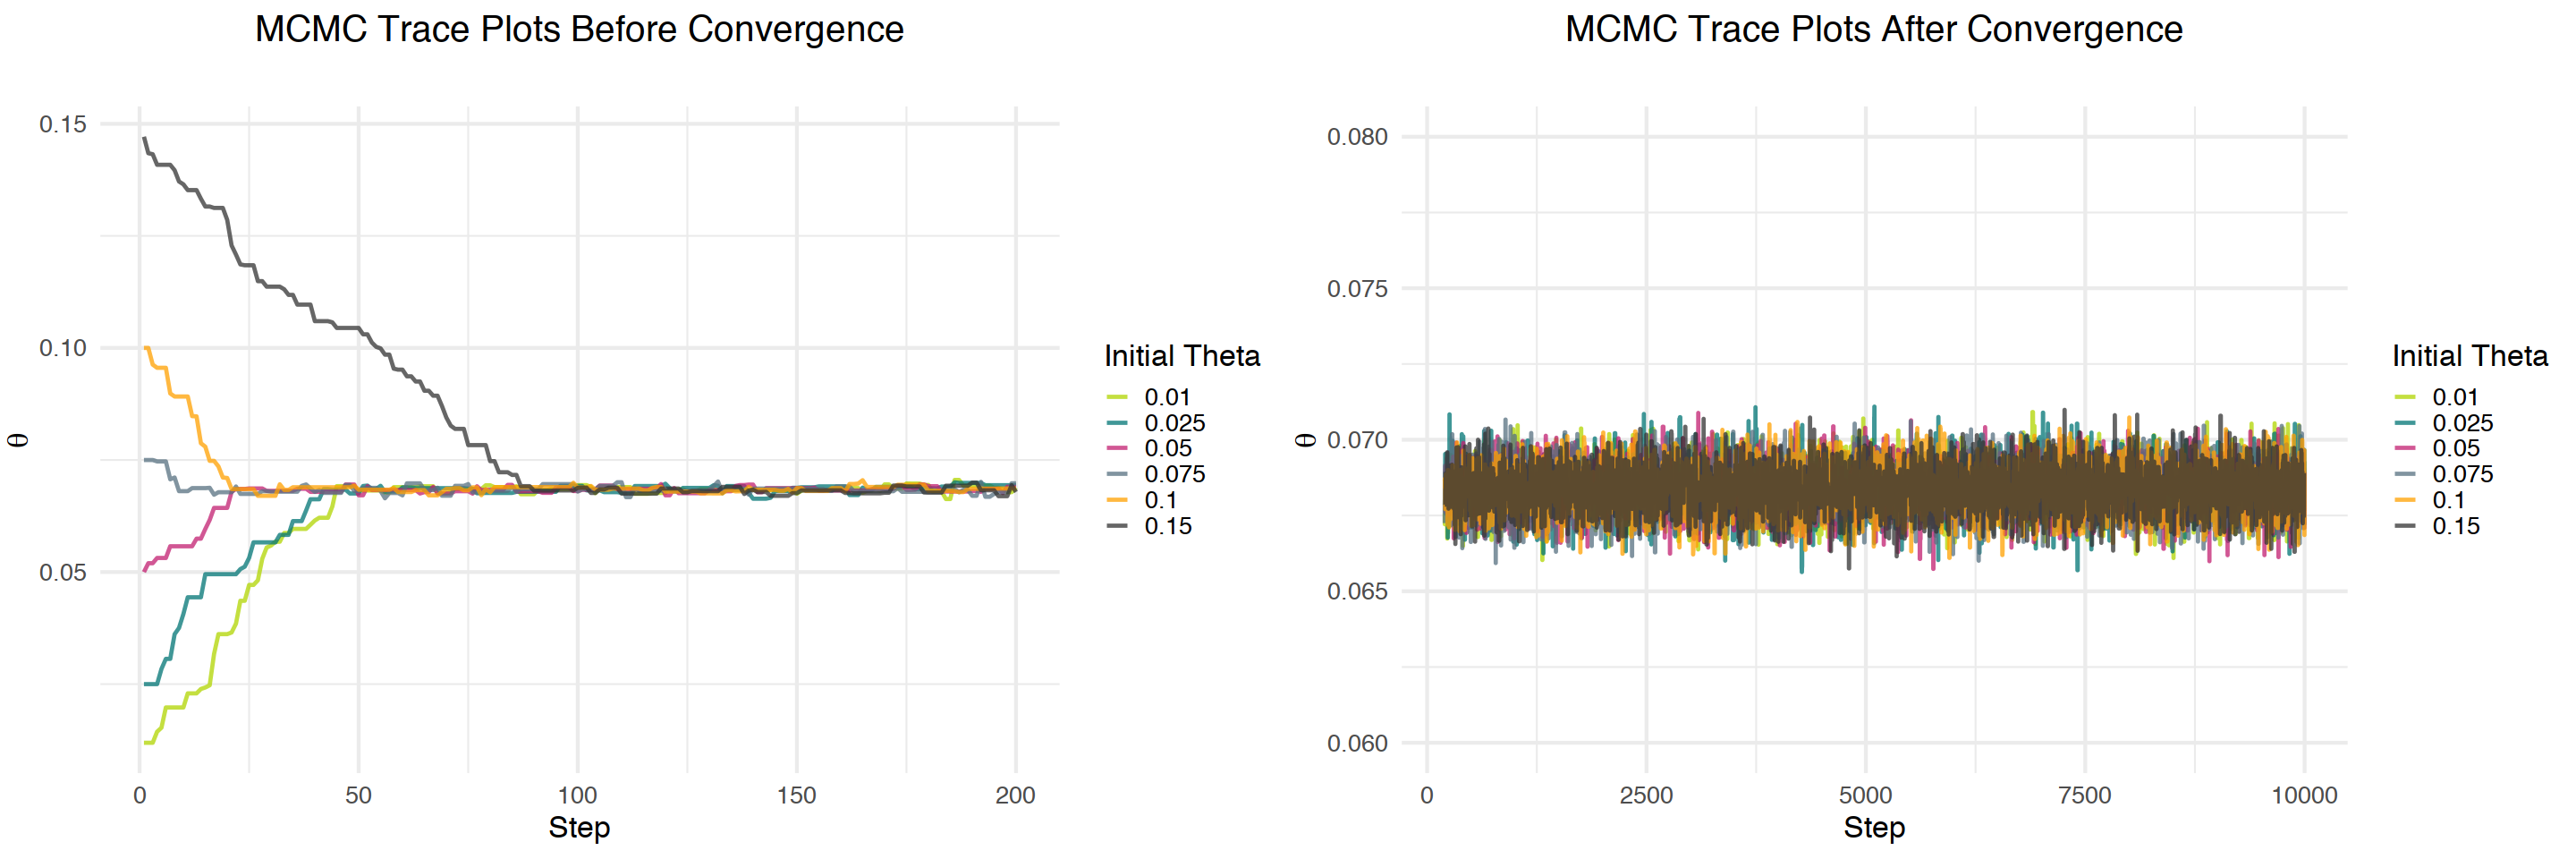

In [38]:
# Show both plots
grid.arrange(trace_plot_start, trace_plot_end, nrow = 1)

### Potential Scale Reduction Factor (PSRF)
The potentual scale reduction factor (PSRF) $\hat{R}$ is one of the most important statistical measures to evaluate the convergence of MCMC. It's based on a __comparison of within-chain and between-chain variances__ of $m>1$ chains with different starting values. Below we look at a variant of PSRF, namely split-$\hat{R}$ which additionally tries to detect a lack of convergence within a single chain. Ideally, we look for values of split-$\hat{R}$ smaller than 1.1. Conversely, values significantly greater than 1 are an indication of poor convergence meaning we need to run the chains longer.

For additional information on the underlying equations please refer to the following references:
- [An improved Rhat for assessing convergence of MCMC](http://www.stat.columbia.edu/~gelman/research/unpublished/1903.08008.pdf) 
- [Coda R Documentation](https://www.rdocumentation.org/packages/coda/versions/0.19-3/topics/gelman.diag)
- [General Methods for Monitoring Convergence of Iterative Simulations](http://www.stat.columbia.edu/~gelman/research/published/brooksgelman2.pdf)

In [40]:
# Function for potential scale reduction factor (Gelman & Rubin, 1992; Gelman et al. (2013))
split_Rhat <- function(chains){
    # Split chains in half
    split_half <- function(chain){split(chain, f = seq_along(chain) <= length(chain)/2)}
    splitted_chains <- unlist(apply(chains, 2, split_half), recursive = FALSE)
        
    # Compute within-chain variance
    W <- mean(sapply(splitted_chains, var))
    
    # Compute between-chain variance B and marginal posterior variance V
    n_samples <- length(splitted_chains[[1]])
    n_chains <- 
    B <- var(sapply(splitted_chains, mean))
    V <- (n-1)/n * W + B
    
    # Compite split-Rhat
    Rhat <- sqrt(V / W)
    
    return(Rhat)
}

In [42]:
# Calculate split-Rhat for chains past burnin
burnin = ceiling(0.1 * nrow(chains))
keep_chains <- chains[-(1:burnin),1:6]

print(paste0("Split-Rhat of chains: ", round(split_Rhat(keep_chains), 5)))

[1] "Split-Rhat of chains: 1.00064"


In addition to a scalar summary we can __plot split-$\hat{R}$__ after $n_{i}$ iterations in order to assess if and when it converges to 1.

In [43]:
# Create a sequence of possible number of samples/steps
n <- nrow(keep_chains)
steps <- seq(from = 100, to = n, by = 100)

# Create vector of 0's to store results
Rhats <- rep(0, length(steps))

# Loop through each step by truncating the chains at the value
# of n and calculate split_Rhat
i <- 1
for (n in steps){
    trim_chain <- function(chain, n){return(chain[1:n])}
    trimmed_chains <- apply(keep_chains, 2, trim_chain, n)
    Rhats[i] <- split_Rhat(trimmed_chains)
    i <- i + 1
}

# Store in data frame for plot
Rhats <- data.frame(steps = steps, rhat = Rhats)

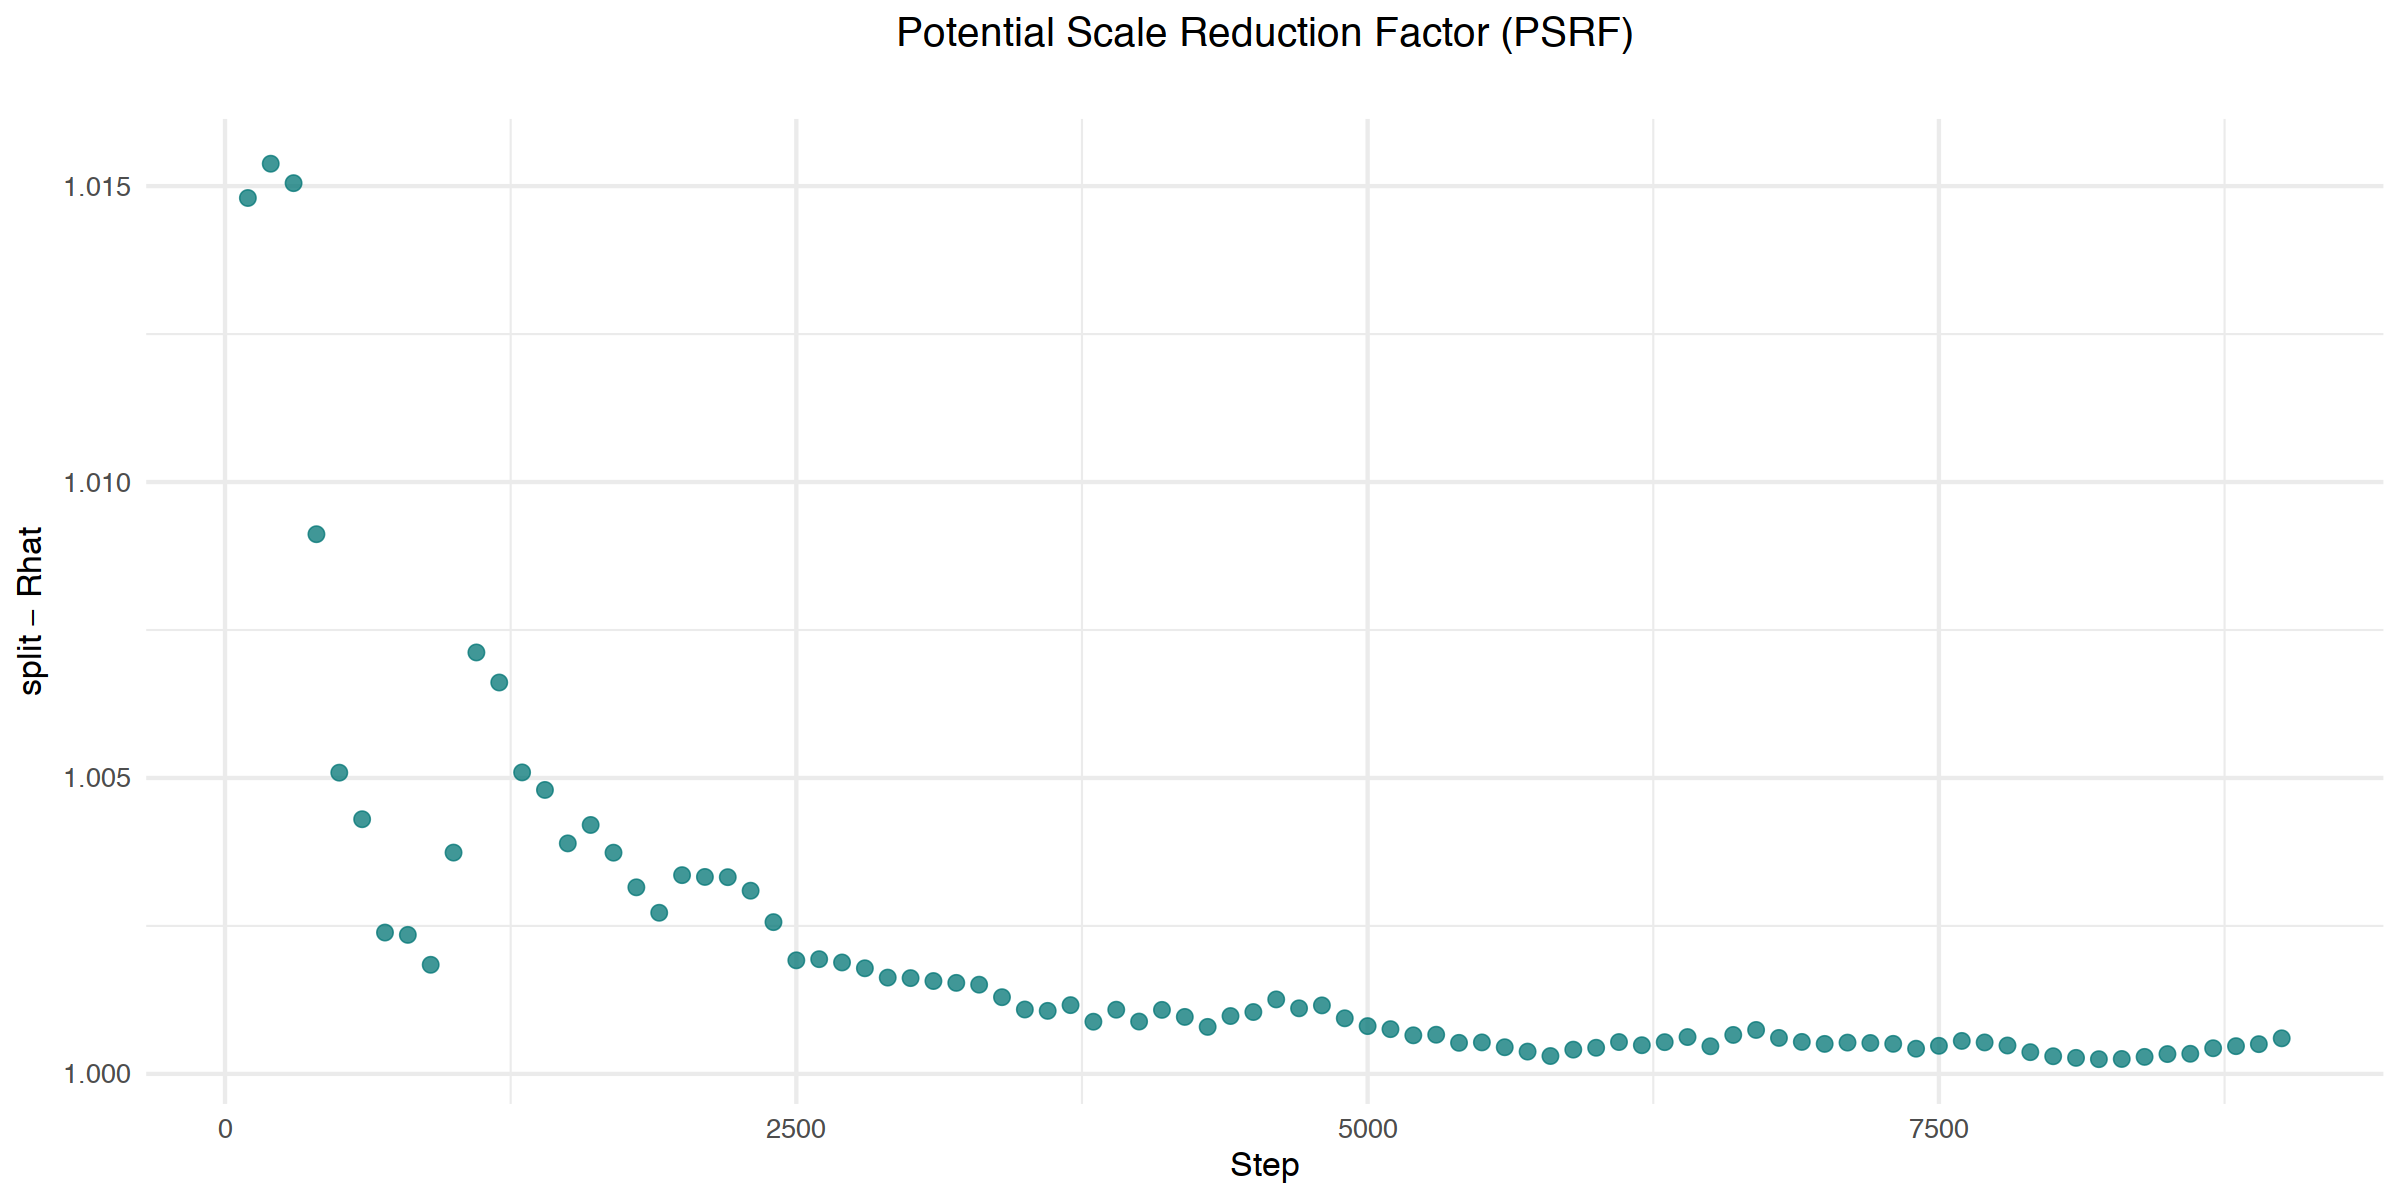

In [44]:
# PSRF plot
options(repr.plot.width=20, repr.plot.height=10)
ggplot(Rhats, aes(x = steps, y = rhat)) + 
    geom_point(size = 4., alpha = 0.75, color = "#007575") +
    labs(title = "Potential Scale Reduction Factor (PSRF)", subtitle = "", x = "Step", y = bquote(split~-~~Rhat)) +
    theme_minimal(base_size = 20) + theme(plot.title = element_text(hjust = 0.5))

### Acceptance Rate
Last but not least we take a look at the acceptance rate of a chain. The acceptance rate represents the __percentage of proposed parameter__ values $\theta_{prop}$ that were __accepted__ during sampling. It's highly influenced by the standard deviation $\sigma$ of the proposal distribution and needs to be tuned to achieve a value of 30-40% (sources differ). In general, decreasing the value of $\sigma$ lowers the acceptance rate (smaller steps) and increasing the value increases the acceptance rate (bigger steps).

In [231]:
acceptance <- apply(chains[,1:6], 2, function(chain) 1 - mean(duplicated(chain)))
acceptance

0.01  0.025   0.05  0.075    0.1   0.15 
0.3283 0.3213 0.3203 0.3228 0.3197 0.3277

## Summary
The goal of this notebook was to ...

## Open Topics
- Sample size and power calculations in Bayesian inference
- Multiple testing in Bayesian inference

## References
- [An improved Rhat for assessing convergence of MCMC](http://www.stat.columbia.edu/~gelman/research/unpublished/1903.08008.pdf) 
- [Baby Bayes Using R](http://www2.stat.duke.edu/~rcs46/books/babybayes-master.pdf)
- [Bayesian Assessment of Null Values](http://doingbayesiandataanalysis.blogspot.com/2016/12/bayesian-assessment-of-null-values.html)
- [Bayesian Data Analysis](https://www.academia.edu/32086149/Bayesian_Data_Analysis_Third_Edition_Gelman_.pdf)
- [Bayesian Estimation Supersedes the t Test](http://www.indiana.edu/~kruschke/articles/Kruschke2013JEPG.pdf)
- [Bayesian Parameter Estimation or Bayesian Hypothesis Testing](https://stats.stackexchange.com/questions/246481/bayesian-parameter-estimation-or-bayesian-hypothesis-testing)
- [BEST Vignette](https://cran.r-project.org/web/packages/BEST/vignettes/BEST.pdf)
- [Book Collection](http://hbiostat.org/bib/bayesteach.html)
- [Coda R Documentation](https://www.rdocumentation.org/packages/coda/versions/0.19-3/topics/gelman.diag)
- [Credible Intervals](https://www.sciencedirect.com/topics/mathematics/credible-interval)
- [Doing Bayesian Data Analysis, 1st Edition](http://www.users.csbsju.edu/~mgass/robert.pdf)
- [Doing Bayesian Data Analysis, 2nd Edition](http://www.r-5.org/files/books/computers/algo-list/statistics/data-mining/John_K_Kruschke-Doing_Bayesian_Data_Analysis-EN.pdf)
- [General Methods for Monitoring Convergence of Iterative Simulations](http://www.stat.columbia.edu/~gelman/research/published/brooksgelman2.pdf)
- [Informative and Noninformative Priors](https://statmodeling.stat.columbia.edu/2007/07/18/informative_and/)
- [MCMC Algorithms](https://www.casact.org/library/studynotes/MASII_mcmc_algorithms_v0.5.pdf)
- [Metropolis–Hastings Algorithm](https://en.wikipedia.org/wiki/Metropolis–Hastings_algorithm)
- [My Journey From Frequentist to Bayesian Statistics](https://www.fharrell.com/post/journey/)
- [Stopping Rules and Bayesian Analyis 1](https://statmodeling.stat.columbia.edu/2014/02/13/stopping-rules-bayesian-analysis/)
- [Stopping Rules and Bayesian Analyis 2](https://statmodeling.stat.columbia.edu/2018/01/03/stopping-rules-bayesian-analysis-2/)
- [The Bayesian New Statistics](https://link.springer.com/article/10.3758/s13423-016-1221-4#Fig2)
- [Why We (Usually) Don’t Have to Worry About Multiple Comparisons](http://www.stat.columbia.edu/~gelman/research/published/multiple2f.pdf)